In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import itertools
import pandas as pd
import pickle
import bikes
import mse
import prediction_plots as pplot
import warnings
from pmdarima import auto_arima
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

In [2]:
master = pd.read_csv('master.csv')

In [3]:
master.set_index('date_of_trip', inplace = True)

In [4]:
master.index = pd.to_datetime(master.index)

In [5]:
master_m = master.resample('m').sum()

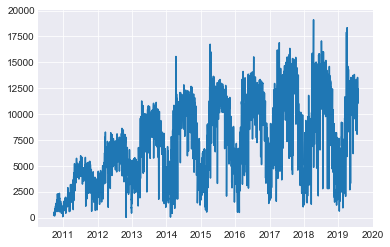

In [6]:
plt.plot(master);

In [7]:
dc_temps = pd.read_csv('dc_temps.csv')
dc_precips = pd.read_csv('dc_precips.csv')

In [8]:
rename_dict = {}
rename_dict['Unnamed: 0'] = 'Year'
dc_temps.rename(columns = rename_dict, inplace = True)
dc_precips.rename(columns = rename_dict, inplace = True)
dc_temps.set_index('Year', inplace = True)
dc_precips.set_index('Year', inplace = True)

In [9]:
dc_temps_stack = dc_temps.stack()
dc_precips_stack = dc_precips.stack()

In [10]:
master_m['avg_temp'] = np.array(dc_temps_stack)
master_m['avg_precips'] = np.array(dc_precips_stack)

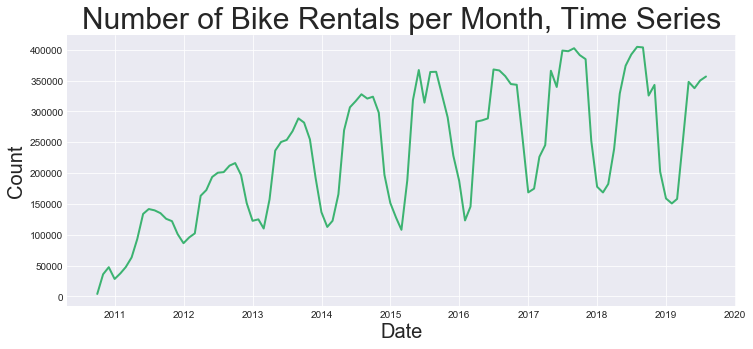

In [130]:
fig = plt.figure(figsize = (12,5))

plt.plot(master_m['count'], lw = 2, color = 'mediumseagreen')

plt.xlabel('Date', fontsize = 20);
plt.ylabel('Count', fontsize = 20);

plt.title('Number of Bike Rentals per Week, Time Series', fontsize = 30);
plt.title('Number of Bike Rentals per Month, Time Series', fontsize = 30);

In [42]:
train_m = master_m[:-18]
test_m = master_m[-18:]

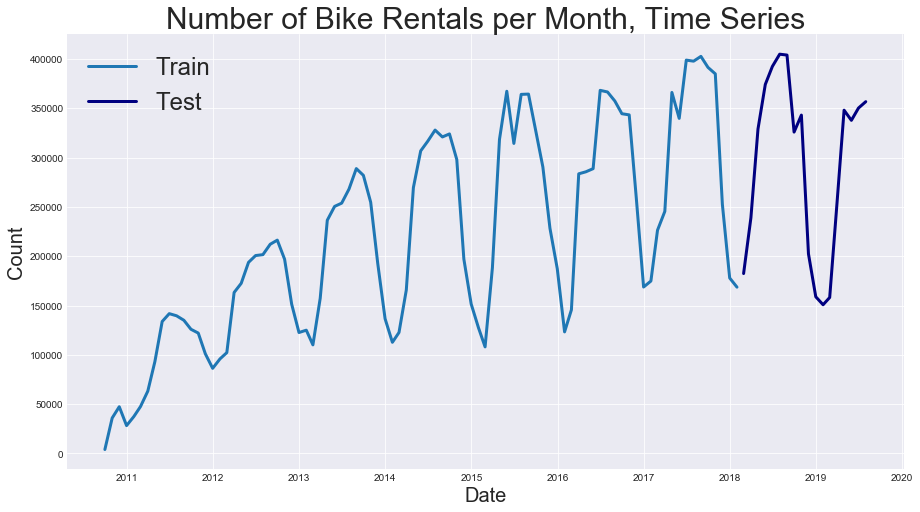

In [43]:
fig = plt.figure(figsize = (15,8))

plt.plot(train_m['count'], lw = 3)
plt.plot(test_m['count'], lw = 3, color = 'navy')
plt.legend(['Train', 'Test'],prop={'size': 24}) 

plt.xlabel('Date', fontsize = 20);
plt.ylabel('Count', fontsize = 20);

plt.title('Number of Bike Rentals per Month, Time Series', fontsize = 30);

<Figure size 432x288 with 0 Axes>

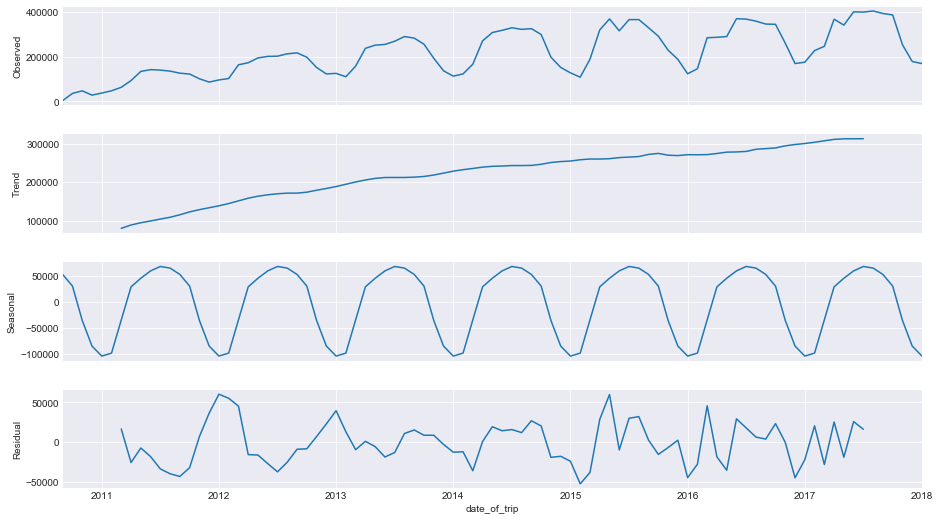

In [44]:
decomposition = seasonal_decompose(train_m['count'], freq=12)
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(15, 8)

In [45]:
def test_stationarity(timeseries, window):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=window).mean()
    rolstd = timeseries.rolling(window=window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries.iloc[window:], color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)


## First Order Difference 

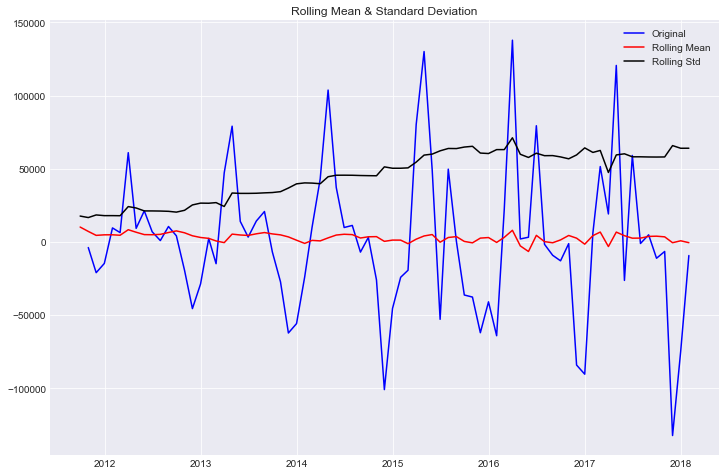

Results of Dickey-Fuller Test:
Test Statistic                 -3.467761
p-value                         0.008855
#Lags Used                     12.000000
Number of Observations Used    75.000000
Critical Value (1%)            -3.520713
Critical Value (5%)            -2.900925
Critical Value (10%)           -2.587781
dtype: float64


In [46]:
train_1_diff = train_m.copy()
train_1_diff['count'] = train_m['count'].diff()
train_1_diff.dropna(inplace = True)
test_stationarity(train_1_diff['count'], 12)

## Second Order Difference

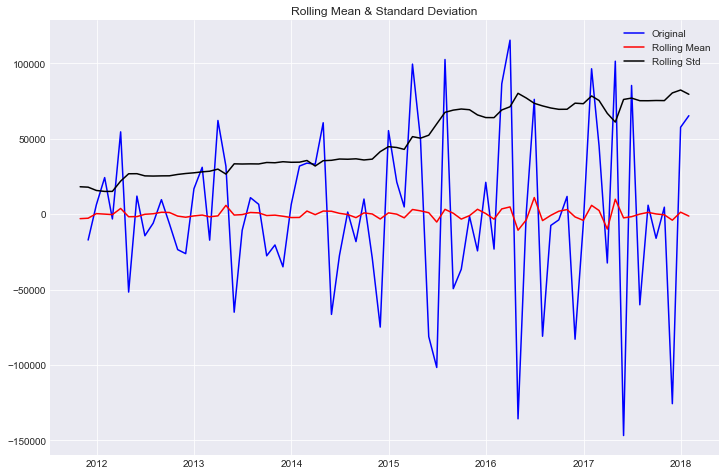

Results of Dickey-Fuller Test:
Test Statistic                -9.831054e+00
p-value                        5.036116e-17
#Lags Used                     1.100000e+01
Number of Observations Used    7.500000e+01
Critical Value (1%)           -3.520713e+00
Critical Value (5%)           -2.900925e+00
Critical Value (10%)          -2.587781e+00
dtype: float64


In [47]:
train_2_diff = train_m.copy()
train_2_diff['count'] = train_m['count'].diff().diff()
train_2_diff.dropna(inplace = True)
test_stationarity(train_2_diff['count'], 12)

## First Seasonal Difference

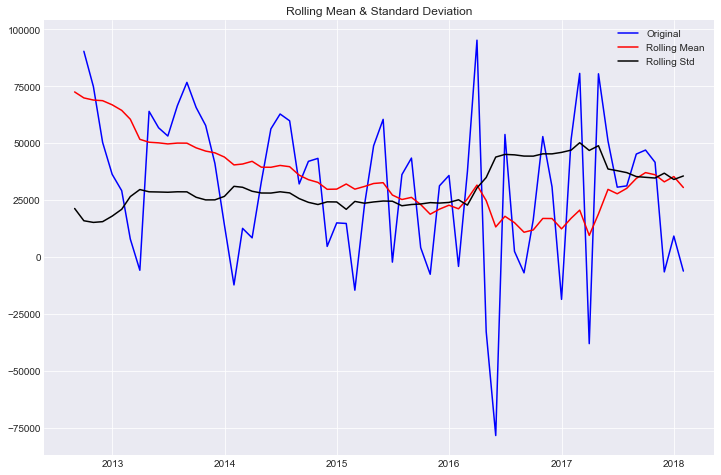

Results of Dickey-Fuller Test:
Test Statistic                 -2.036734
p-value                         0.270702
#Lags Used                      9.000000
Number of Observations Used    67.000000
Critical Value (1%)            -3.531955
Critical Value (5%)            -2.905755
Critical Value (10%)           -2.590357
dtype: float64


In [48]:
train_1_season = train_m.copy()
train_1_season = train_1_season - train_1_season.shift(12)
train_1_season.dropna(inplace = True)
test_stationarity(train_1_season['count'], 12)

## First Seasonal Difference of First Order Difference

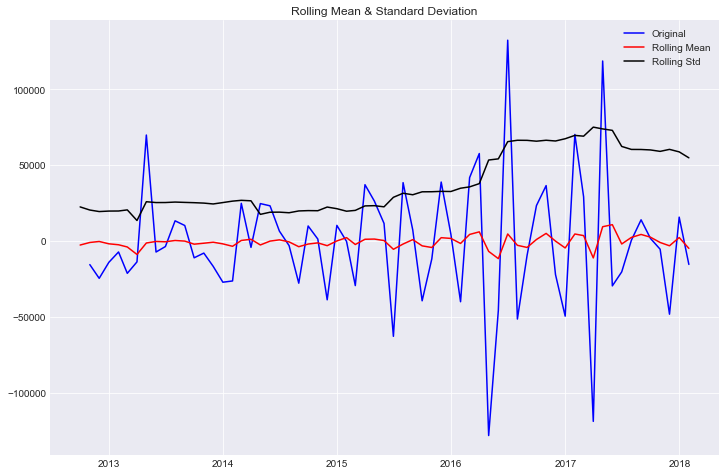

Results of Dickey-Fuller Test:
Test Statistic                 -5.567006
p-value                         0.000001
#Lags Used                      8.000000
Number of Observations Used    67.000000
Critical Value (1%)            -3.531955
Critical Value (5%)            -2.905755
Critical Value (10%)           -2.590357
dtype: float64


In [49]:
train_1_season_diff_1_diff = train_1_diff.copy()
train_1_season_diff_1_diff['count'] = train_1_season_diff_1_diff['count'] - train_1_season_diff_1_diff['count'].shift(12)
train_1_season_diff_1_diff.dropna(inplace = True)
test_stationarity(train_1_season_diff_1_diff['count'], 12)

## This suggests, d = 1, D = 1. Now look at ACF and PACF.

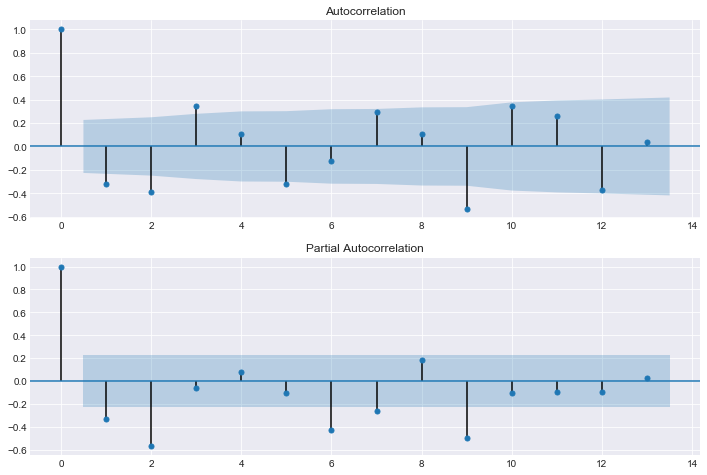

In [50]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
#plot the ACF
fig = sm.graphics.tsa.plot_acf(train_1_season_diff_1_diff['count'].iloc[1:], lags=13, ax=ax1)
ax2 = fig.add_subplot(212)
#plot the PACF
fig = sm.graphics.tsa.plot_pacf(train_1_season_diff_1_diff['count'].iloc[1:], lags=13, ax=ax2)

# AFC looks good. PAFC suggests 2 significant lags (p = 2). AFC suggests q = 1- 3.

## Models to try:

#### (2,1,0)(0,1,0,12)
#### (2,1,0)(0,1,1,12)
#### (2,1,0)(1,1,0,12)
#### (2,1,1)(0,1,0,12)
#### (2,1,1)(0,1,1,12)
#### (2,1,1)(1,1,0,12)
#### (2,1,2)(0,1,0,12)
#### (2,1,2)(0,1,1,12)
#### (2,1,2)(1,1,0,12)
#### (2,1,3)(0,1,0,12)
#### (2,1,3)(0,1,1,12)
#### (2,1,3)(1,1,0,12)

In [51]:
orders = [(2,1,0),(2,1,1),(2,1,2),(2,1,3)]
seasonal_orders = [(0,1,0,12),(1,1,0,12),(0,1,1,12)]

                                 Statespace Model Results                                 
Dep. Variable:                              count   No. Observations:                   89
Model:             SARIMAX(2, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -896.416
Date:                            Tue, 10 Sep 2019   AIC                           1798.833
Time:                                    13:01:34   BIC                           1805.825
Sample:                                09-30-2010   HQIC                          1801.627
                                     - 01-31-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4669      0.063     -7.463      0.000      -0.590      -0.344
ar.L2         -0.5244      0.078   

Training MSE:  1.00e+09
Testing MSE:  1.08e+09
                                 Statespace Model Results                                 
Dep. Variable:                              count   No. Observations:                   89
Model:             SARIMAX(2, 1, 1)x(1, 1, 0, 12)   Log Likelihood                -895.791
Date:                            Tue, 10 Sep 2019   AIC                           1801.582
Time:                                    13:01:35   BIC                           1813.236
Sample:                                09-30-2010   HQIC                          1806.240
                                     - 01-31-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4563      0.271     -1.687      0.092      -0.987 

                                 Statespace Model Results                                 
Dep. Variable:                              count   No. Observations:                   89
Model:             SARIMAX(2, 1, 2)x(0, 1, 1, 12)   Log Likelihood                -890.763
Date:                            Tue, 10 Sep 2019   AIC                           1793.525
Time:                                    13:01:37   BIC                           1807.509
Sample:                                09-30-2010   HQIC                          1799.114
                                     - 01-31-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2962      0.095     -3.109      0.002      -0.483      -0.109
ar.L2         -0.8991      0.058   

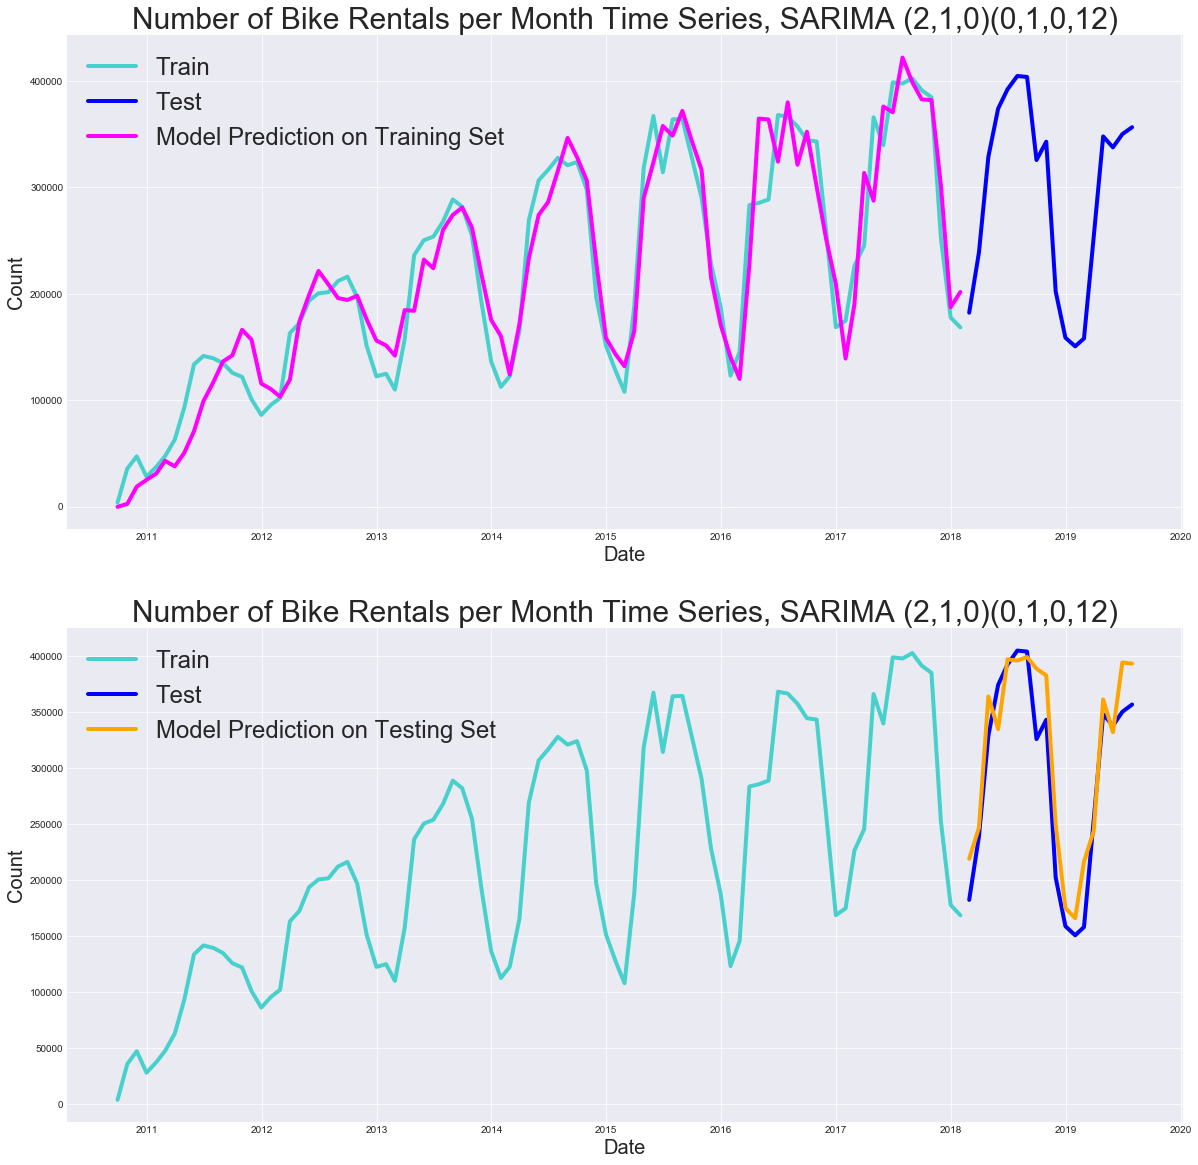

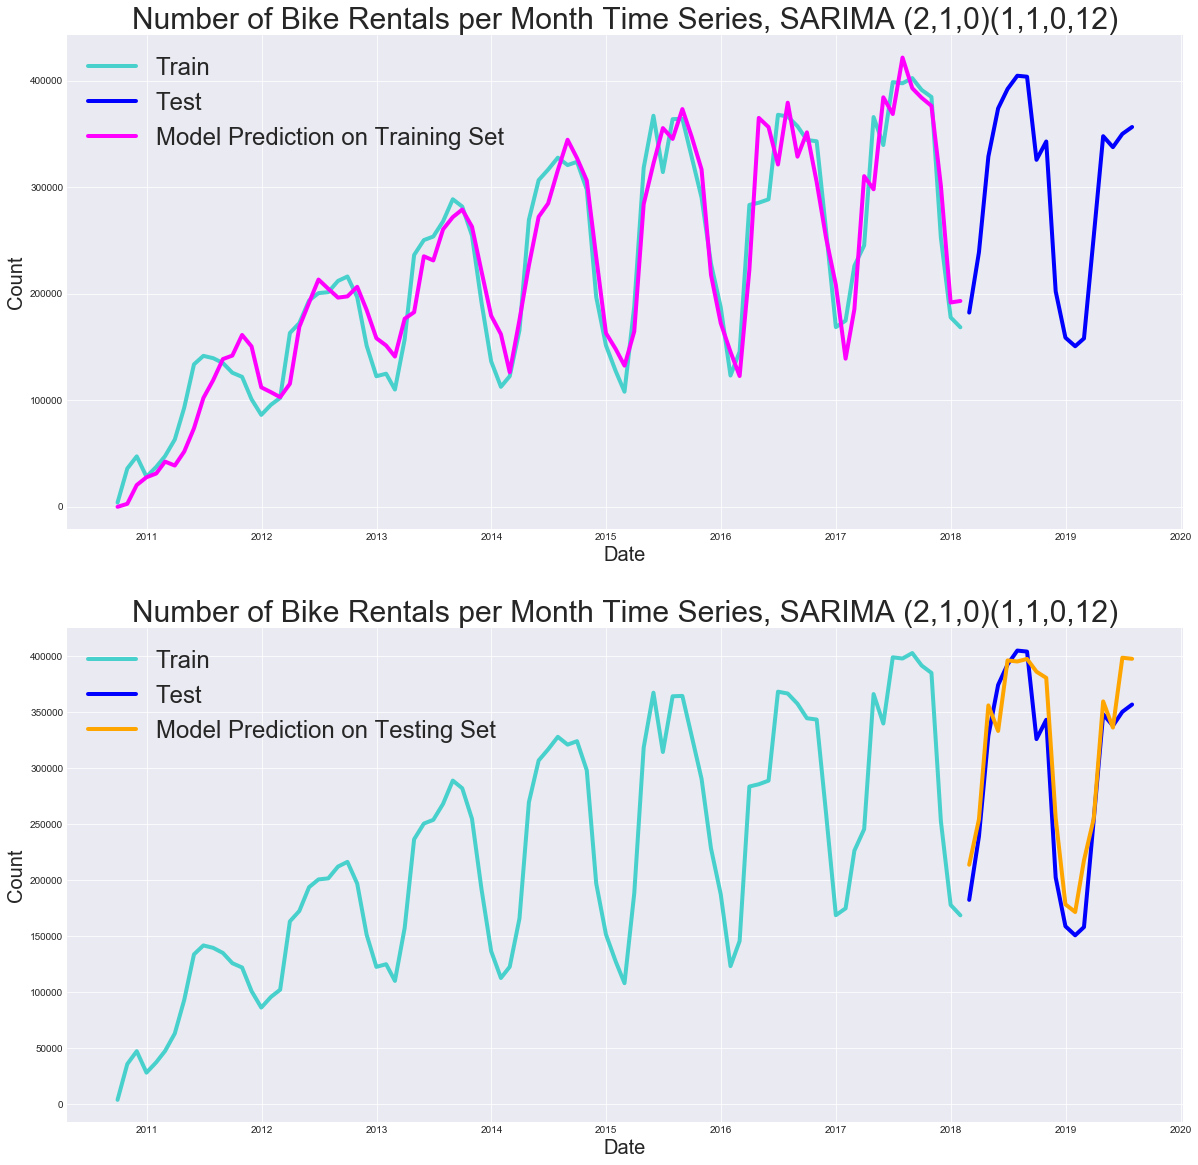

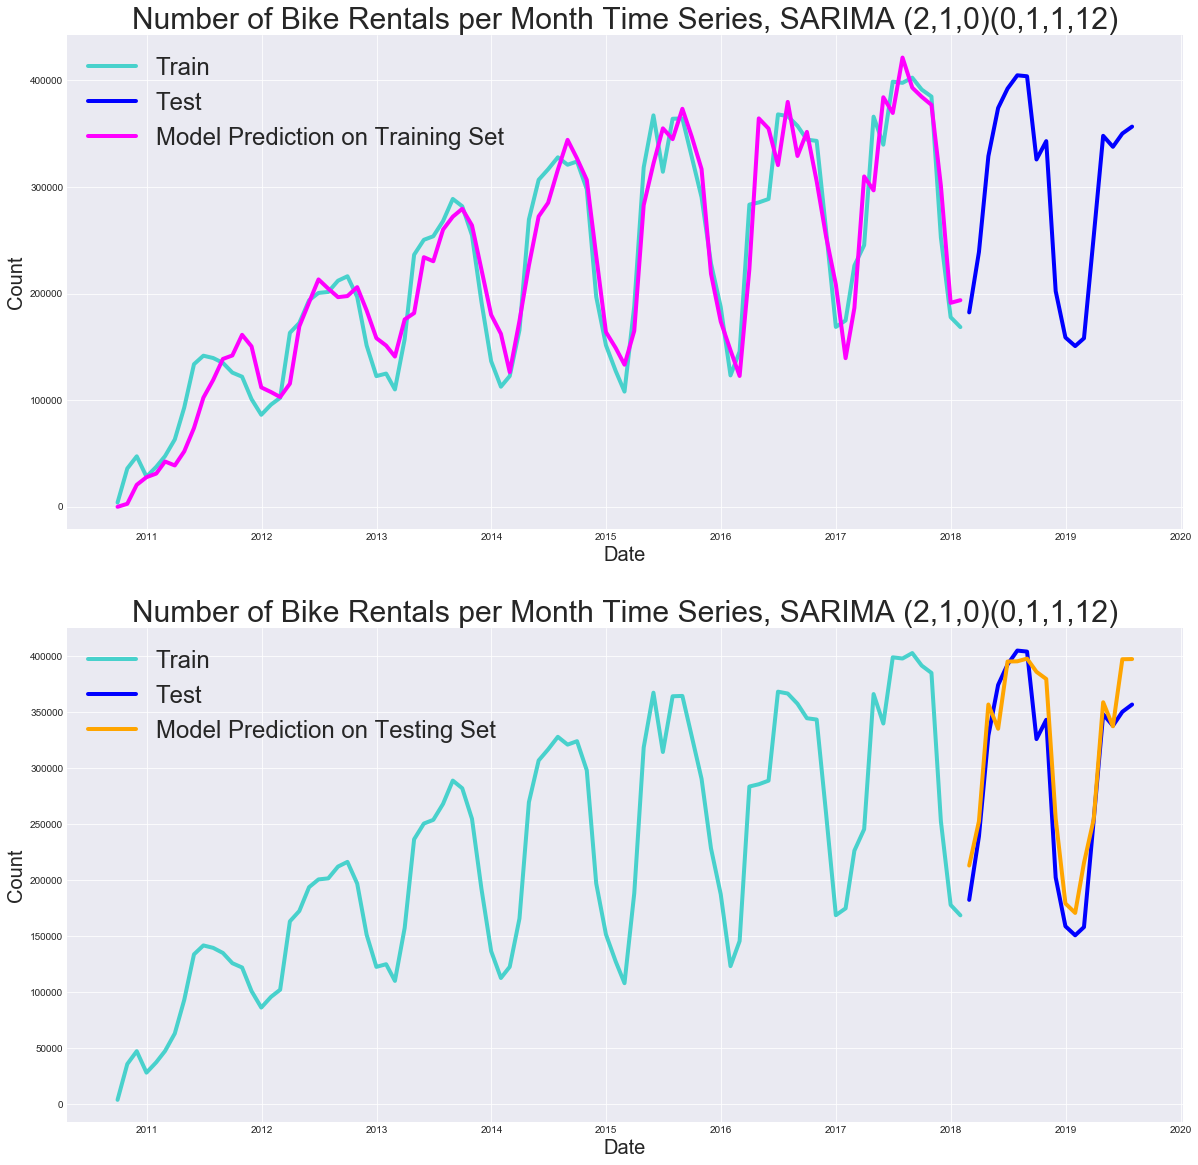

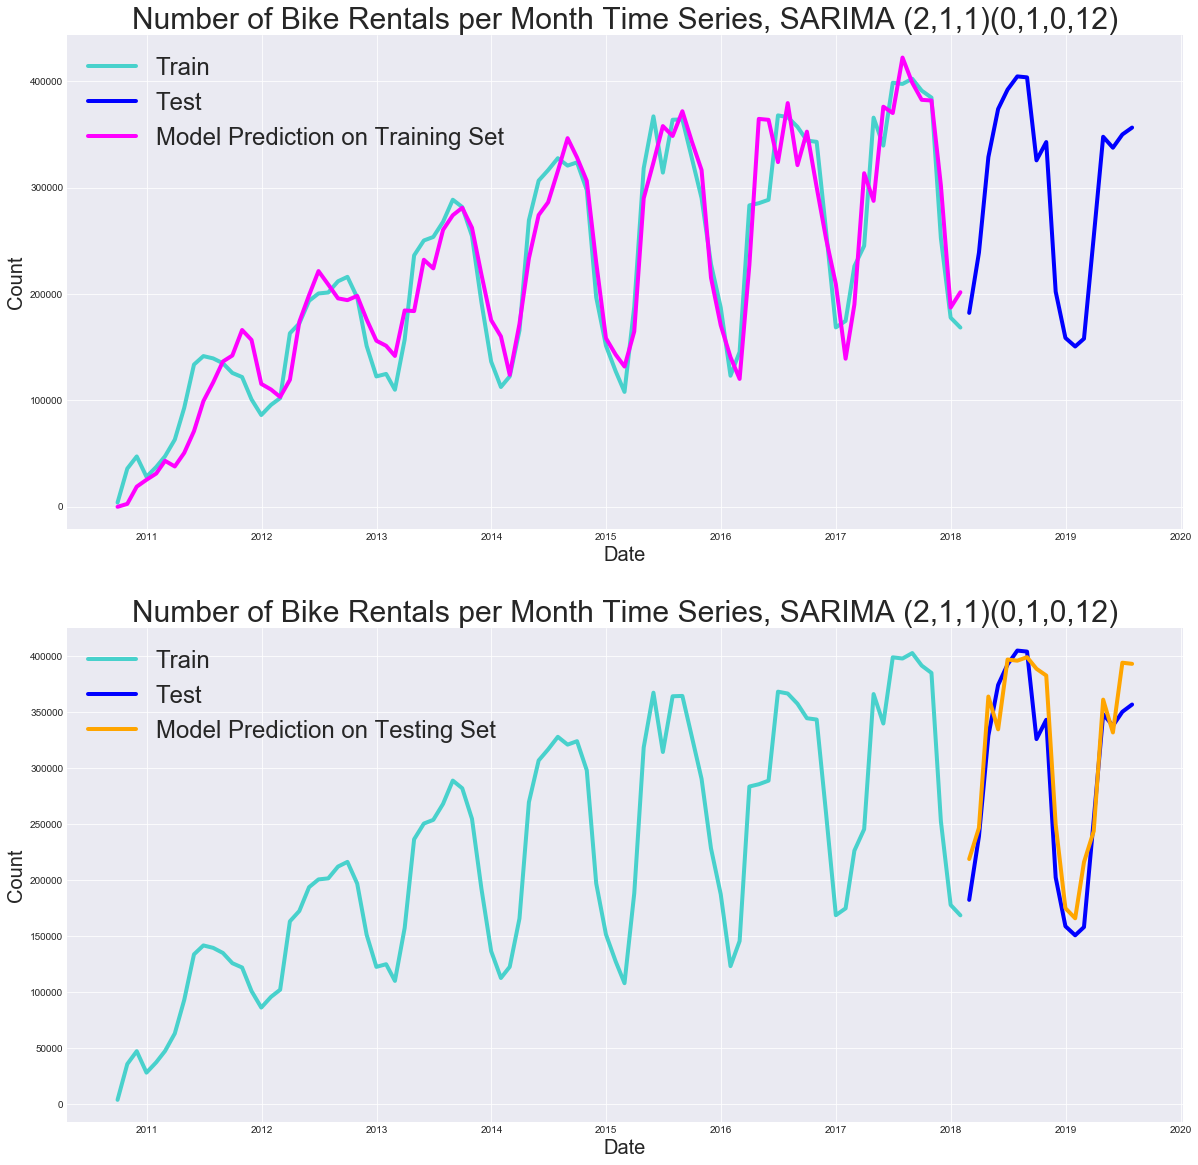

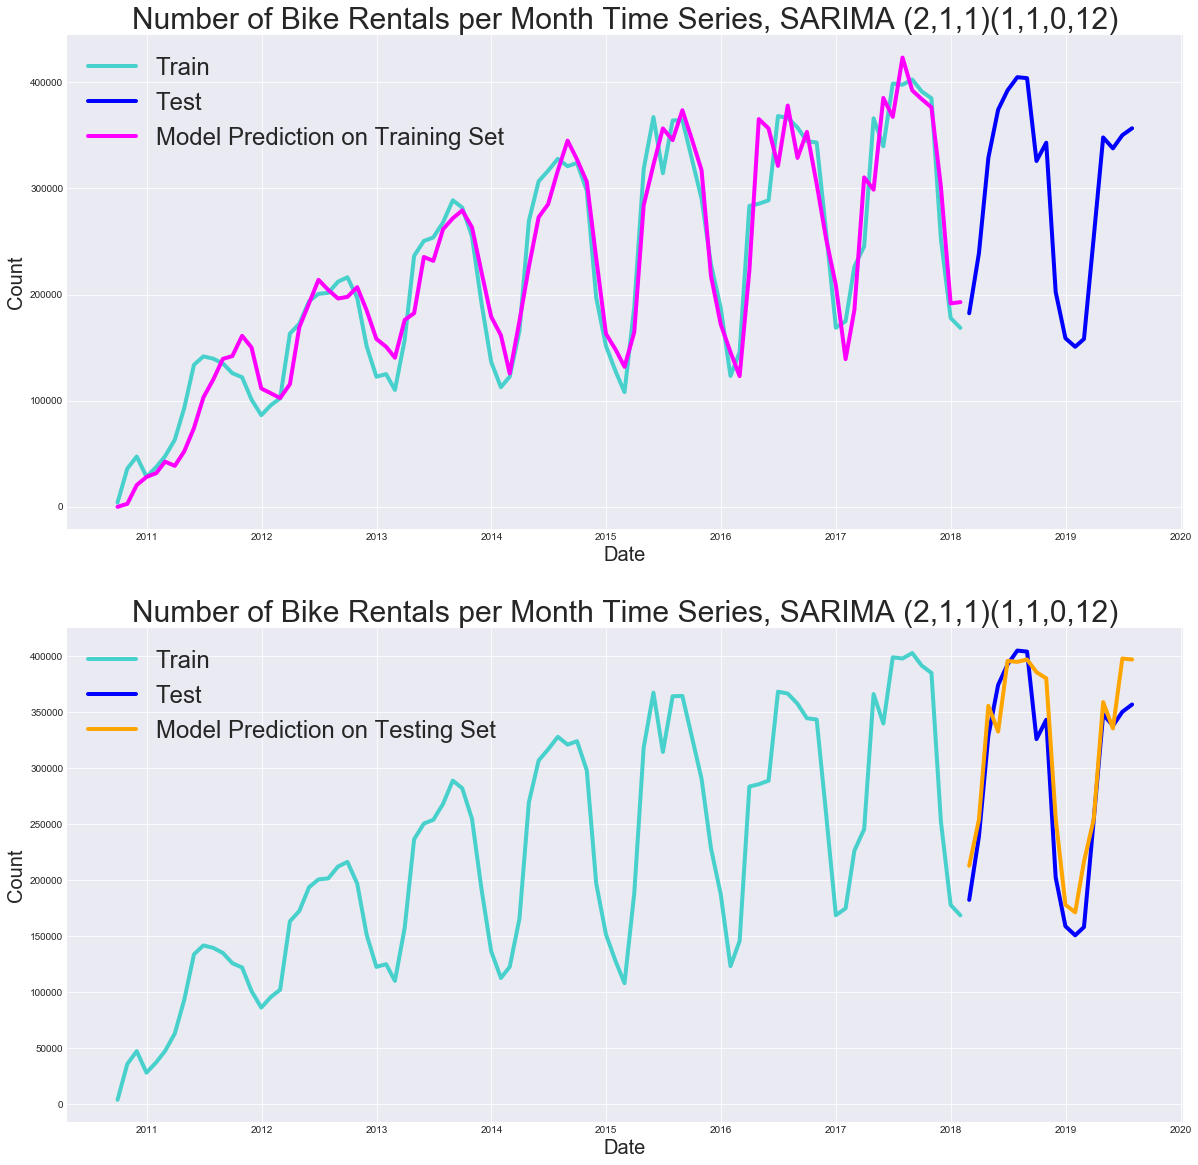

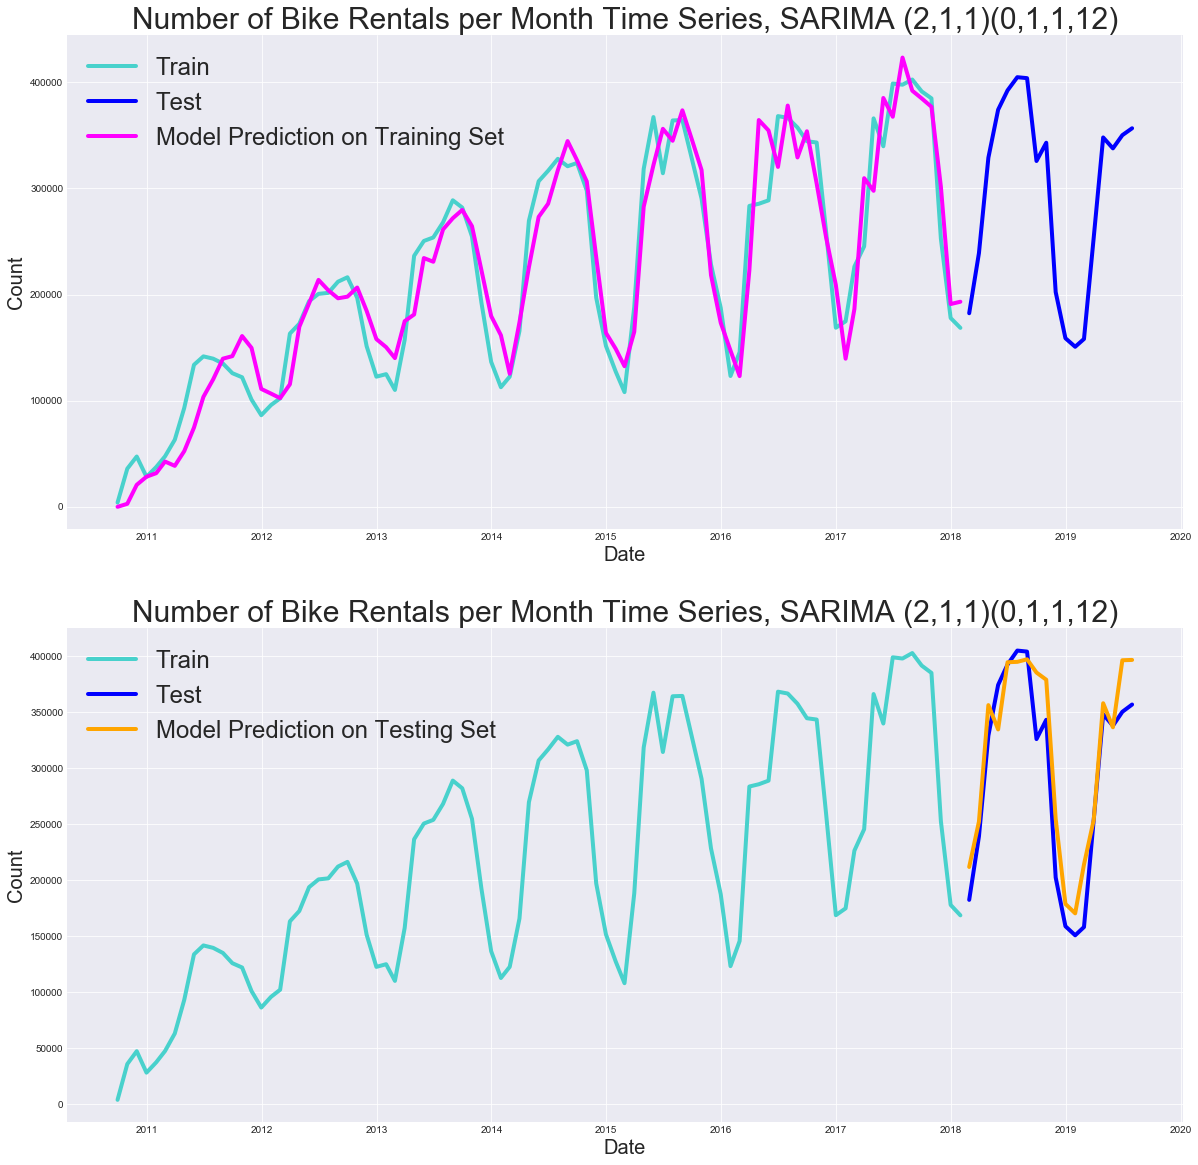

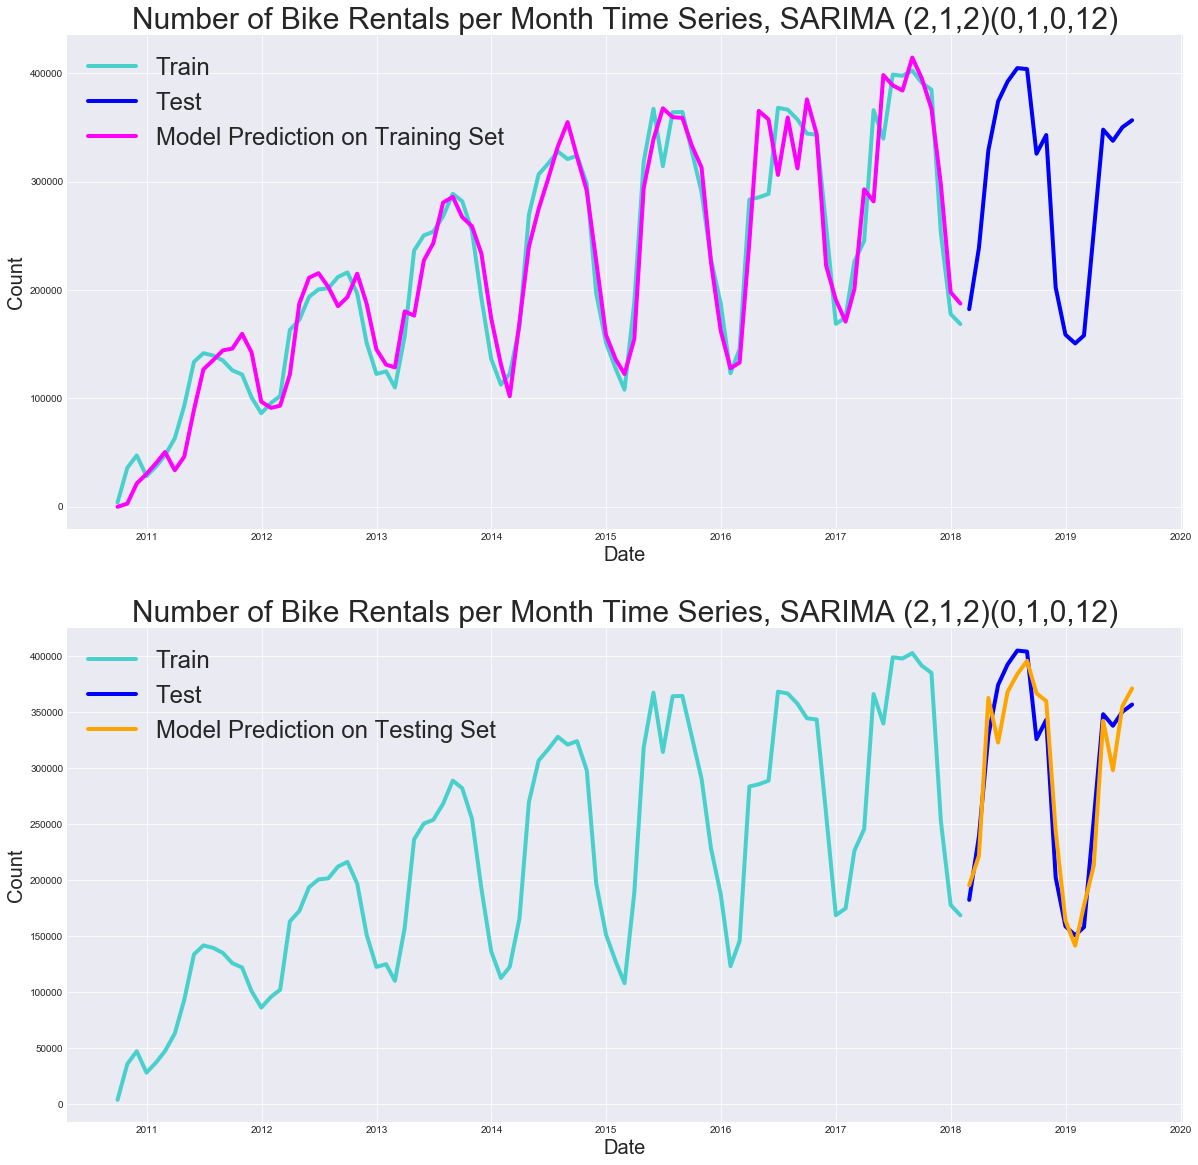

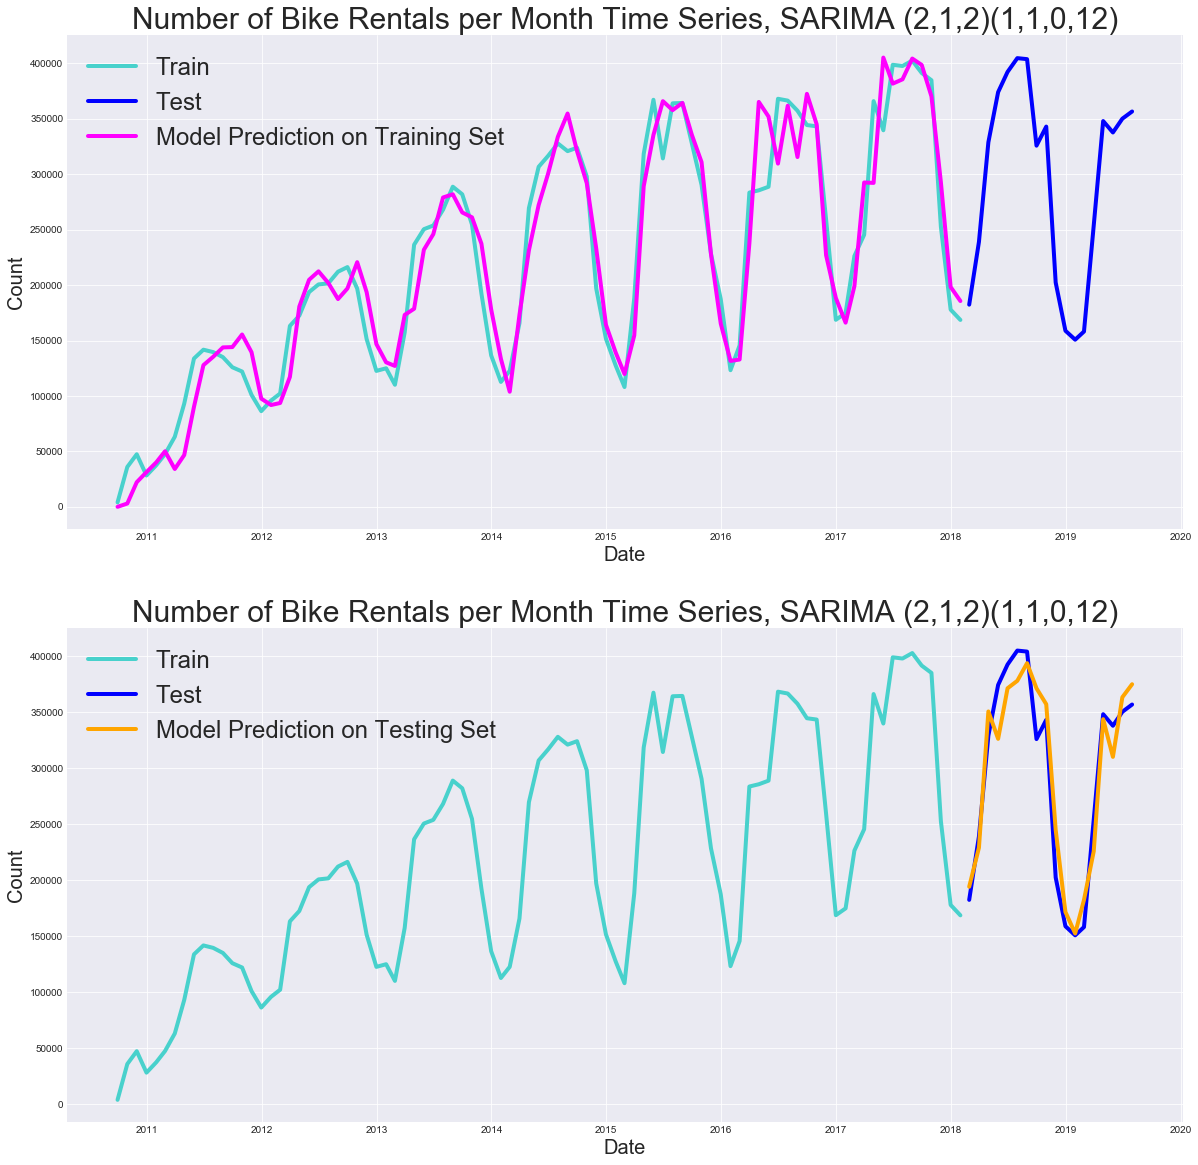

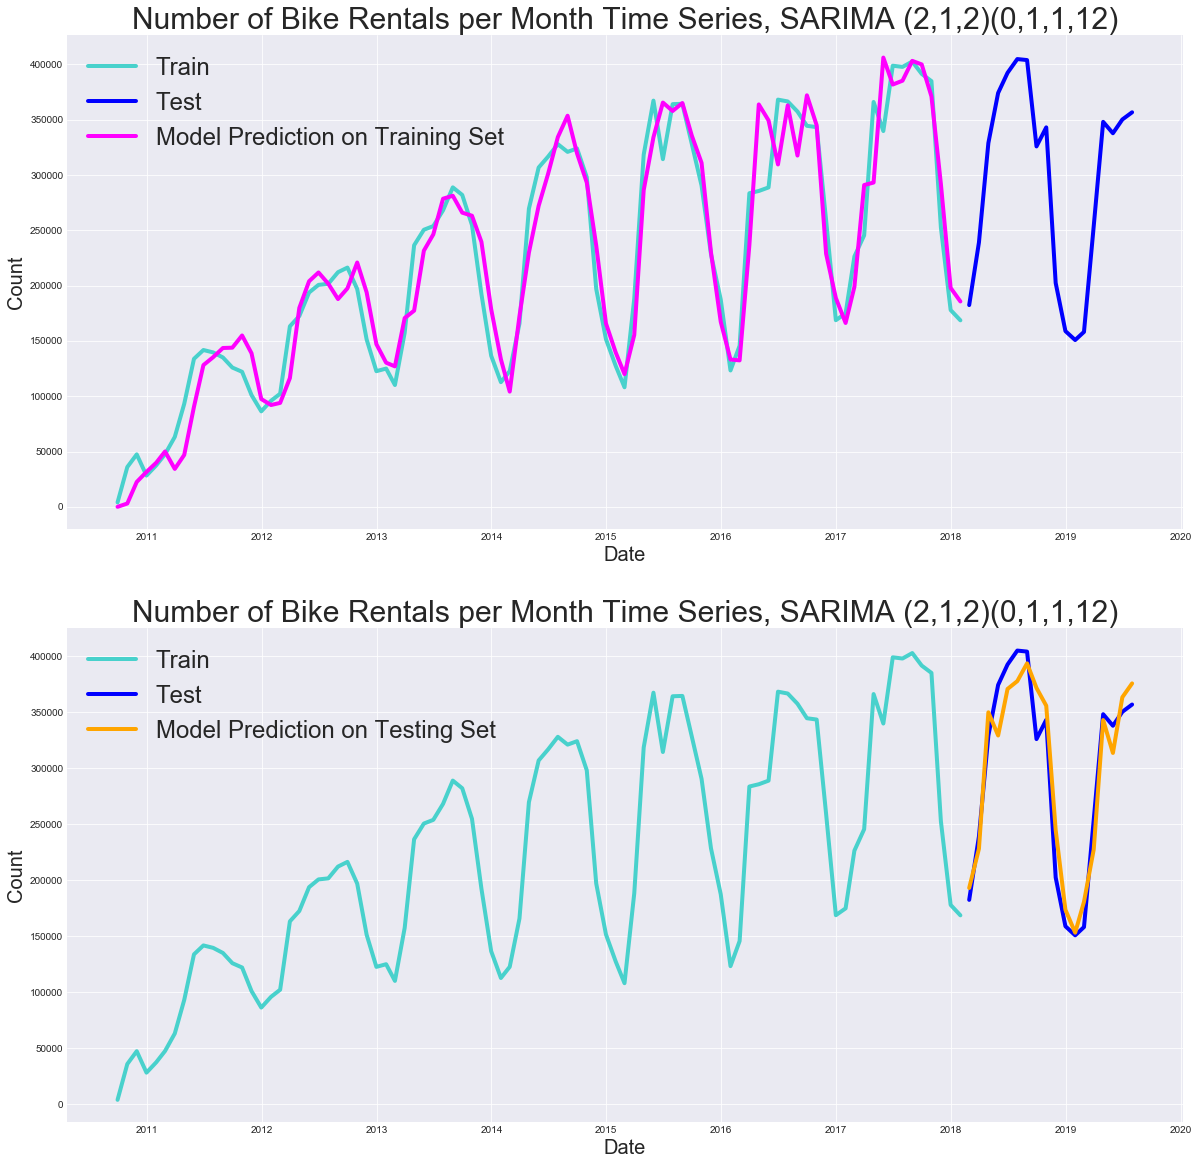

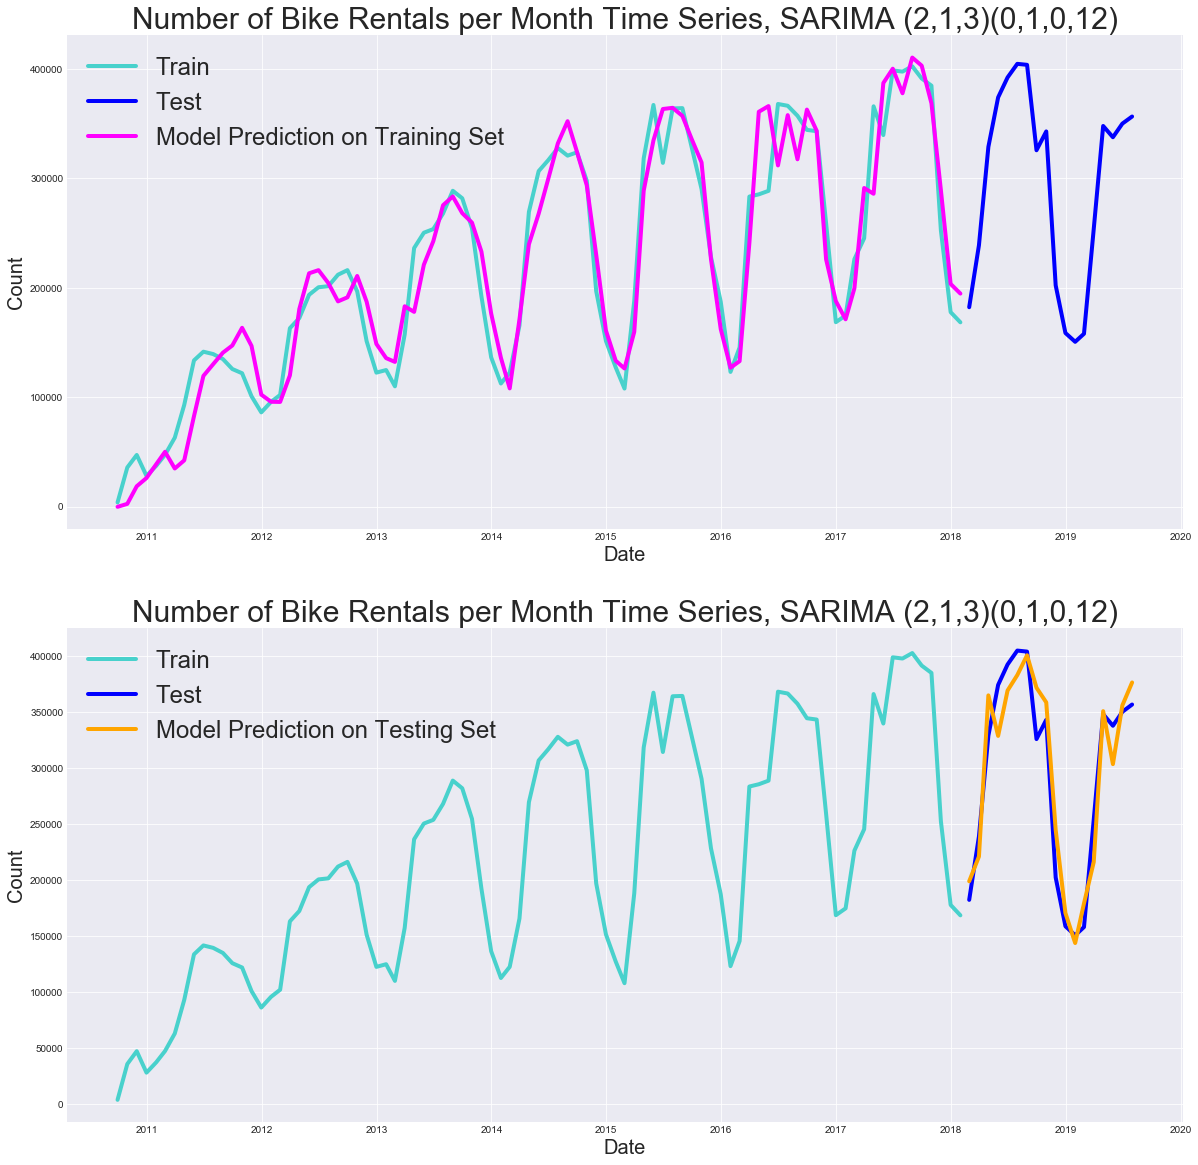

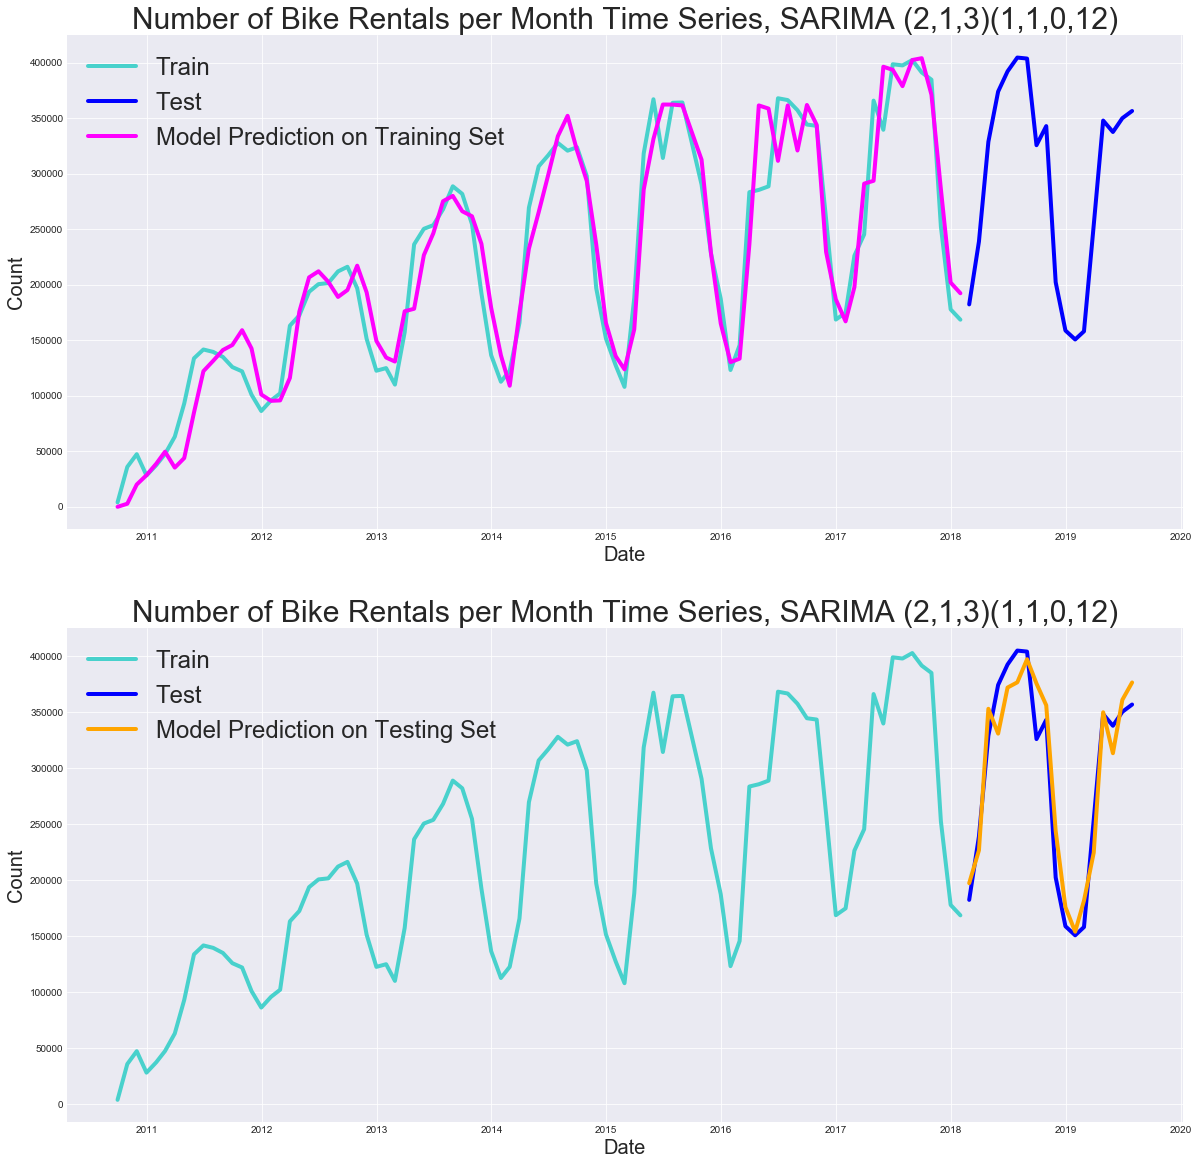

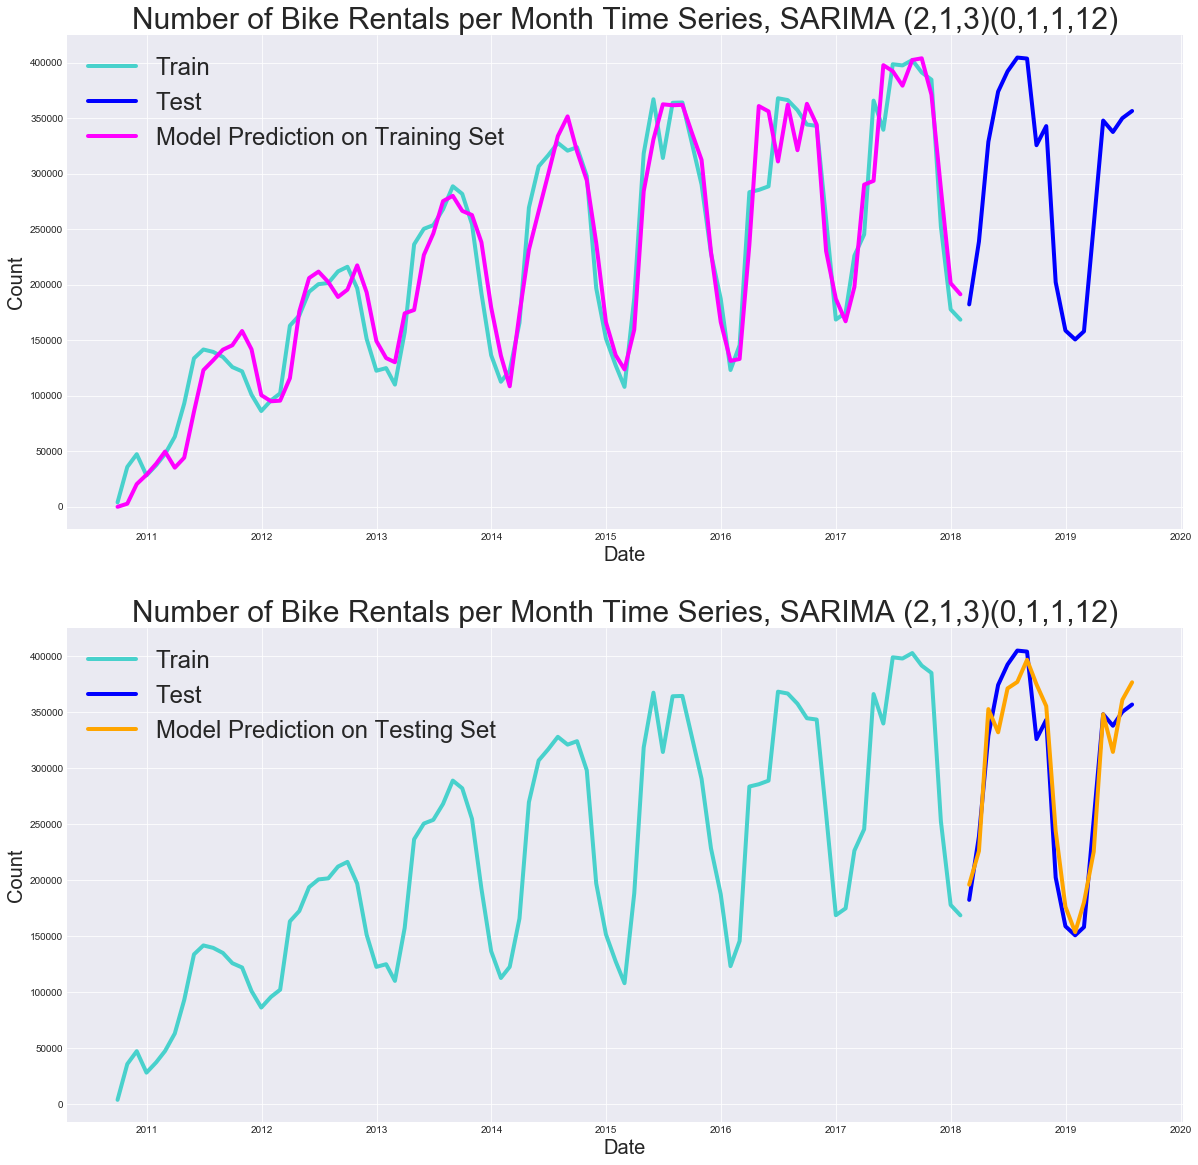

In [52]:
mse_dict = {}

for o in orders:   
    for s_o in seasonal_orders:
        model = sm.tsa.statespace.SARIMAX(train_m['count'], order=(o[0],o[1],o[2]), 
                                          seasonal_order=(s_o[0],s_o[1],s_o[2],s_o[3])).fit()
        print(model.summary())
        train_mse, test_mse = mse.compare_mse(model, train_m, test_m)
        pplot.prediction_plot(model, train_m, test_m, o[0],o[1],o[2],s_o[0],s_o[1],s_o[2],s_o[3])
        
        mse_dict[f'{o},{s_o}'] = {'Training MSE': "{:.2e}".format(train_mse), 'Testing MSE': "{:.2e}".format(test_mse)}
        

In [53]:
mse_dict

{'(2, 1, 0),(0, 1, 0, 12)': {'Training MSE': '1.00e+09',
  'Testing MSE': '1.08e+09'},
 '(2, 1, 0),(1, 1, 0, 12)': {'Training MSE': '9.78e+08',
  'Testing MSE': '1.12e+09'},
 '(2, 1, 0),(0, 1, 1, 12)': {'Training MSE': '9.77e+08',
  'Testing MSE': '1.07e+09'},
 '(2, 1, 1),(0, 1, 0, 12)': {'Training MSE': '1.00e+09',
  'Testing MSE': '1.08e+09'},
 '(2, 1, 1),(1, 1, 0, 12)': {'Training MSE': '9.75e+08',
  'Testing MSE': '1.09e+09'},
 '(2, 1, 1),(0, 1, 1, 12)': {'Training MSE': '9.73e+08',
  'Testing MSE': '1.04e+09'},
 '(2, 1, 2),(0, 1, 0, 12)': {'Training MSE': '8.52e+08',
  'Testing MSE': '7.23e+08'},
 '(2, 1, 2),(1, 1, 0, 12)': {'Training MSE': '8.35e+08',
  'Testing MSE': '6.21e+08'},
 '(2, 1, 2),(0, 1, 1, 12)': {'Training MSE': '8.31e+08',
  'Testing MSE': '5.90e+08'},
 '(2, 1, 3),(0, 1, 0, 12)': {'Training MSE': '8.56e+08',
  'Testing MSE': '7.10e+08'},
 '(2, 1, 3),(1, 1, 0, 12)': {'Training MSE': '8.39e+08',
  'Testing MSE': '6.26e+08'},
 '(2, 1, 3),(0, 1, 1, 12)': {'Training MSE'

## Best three are (2,1,2)(0,1,0,12), (2,1,2)(0,1,1,12), and (2,1,2)(1,1,0,12).

In [54]:
model_212_01012 = sm.tsa.statespace.SARIMAX(train_m['count'], trend='n', order=(2,1,2), 
                                          seasonal_order=(0,1,0,12)).fit()
model_212_01112 = sm.tsa.statespace.SARIMAX(train_m['count'], trend='n', order=(2,1,2), 
                                          seasonal_order=(0,1,1,12)).fit()
model_212_11012 = sm.tsa.statespace.SARIMAX(train_m['count'], trend='n', order=(2,1,2), 
                                          seasonal_order=(1,1,0,12)).fit()

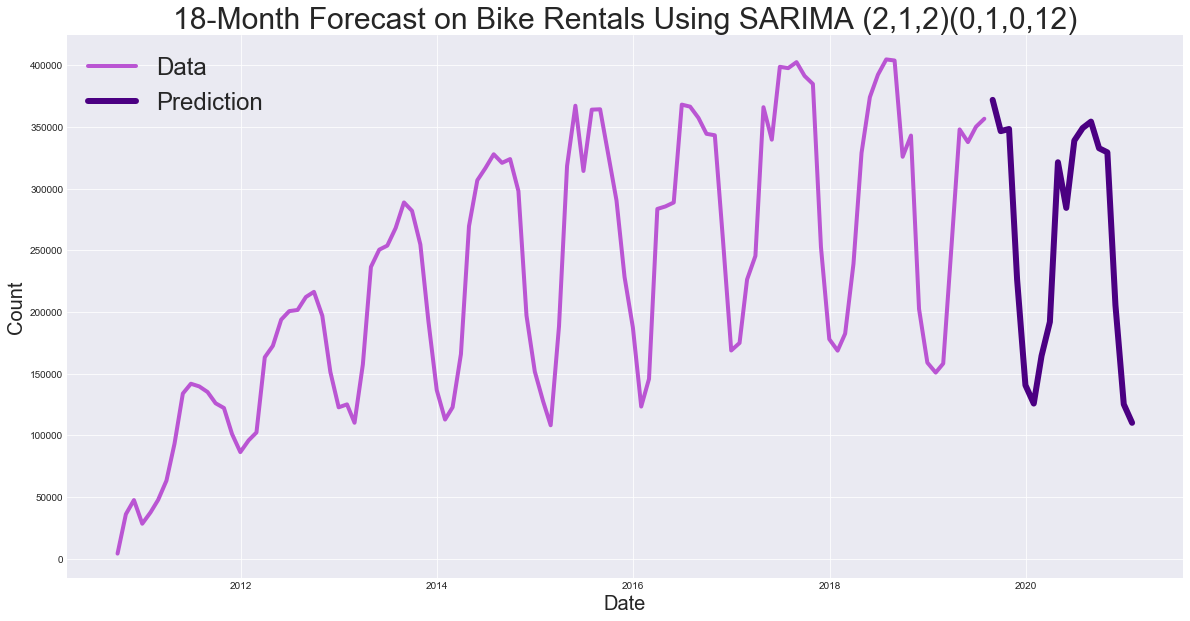

In [55]:
pplot.forecast_plot(model_212_01012,master_m,18,2,1,2,0,1,0,12)

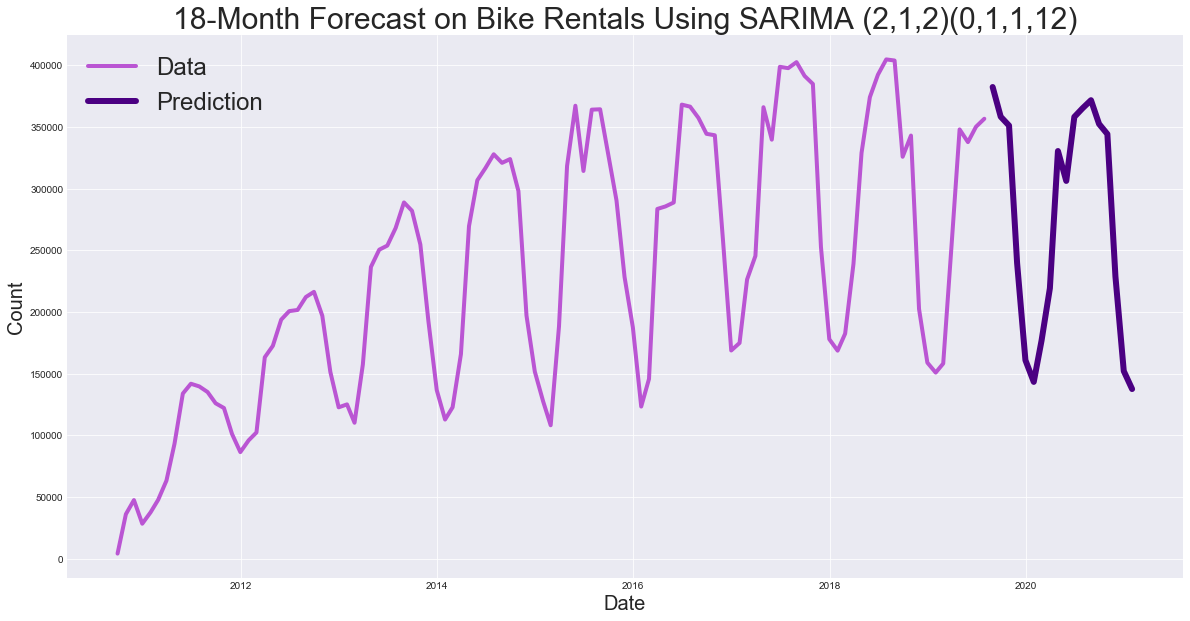

In [56]:
pplot.forecast_plot(model_212_01112,master_m,18,2,1,2,0,1,1,12)

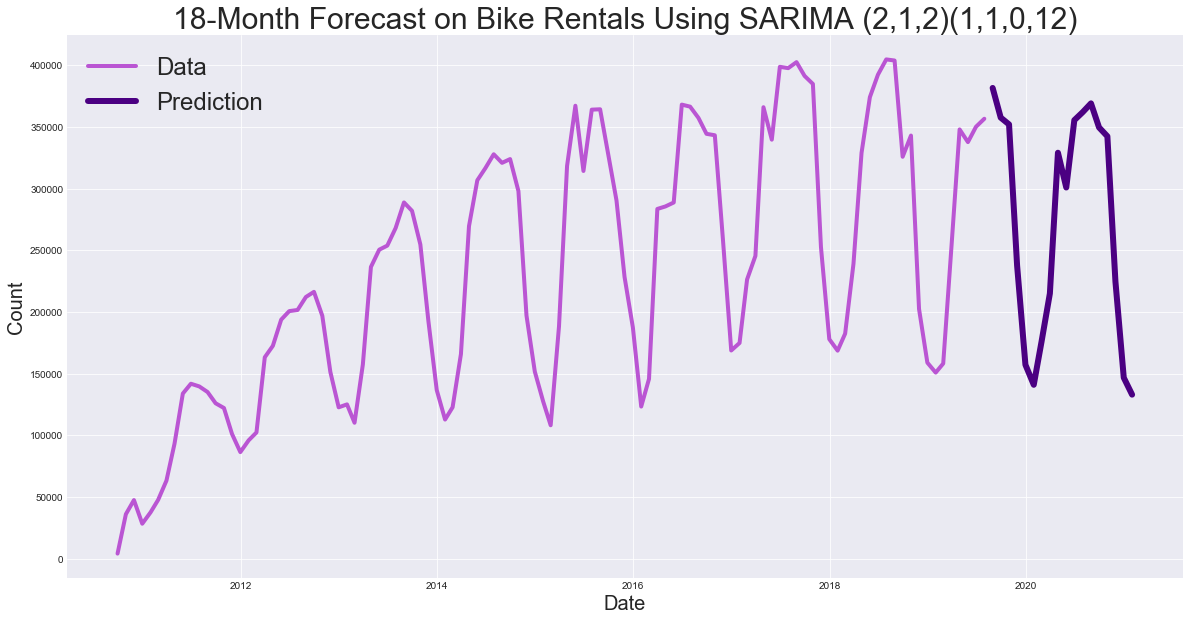

In [57]:
pplot.forecast_plot(model_212_11012,master_m,18,2,1,2,1,1,0,12)

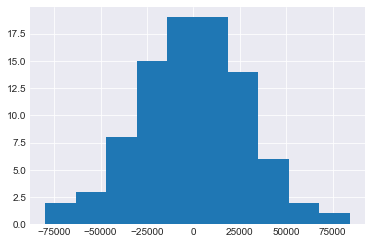

In [58]:
model_212_01012.resid.hist()

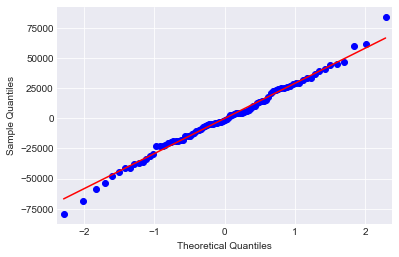

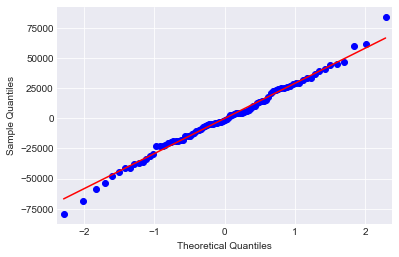

In [60]:
qqplot(model_212_01012.resid, line = 's' )

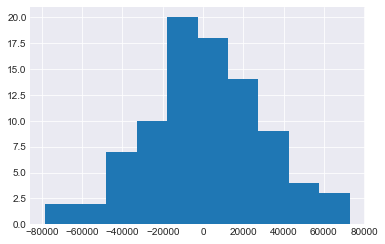

In [61]:
model_212_01112.resid.hist()

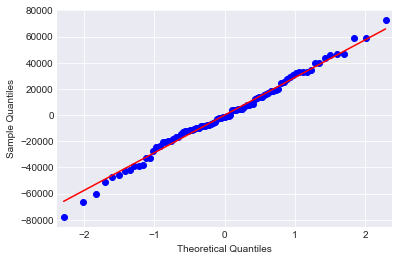

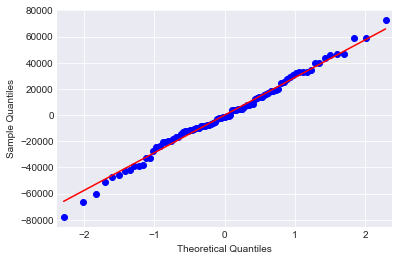

In [62]:
qqplot(model_212_01112.resid, line = 's' )

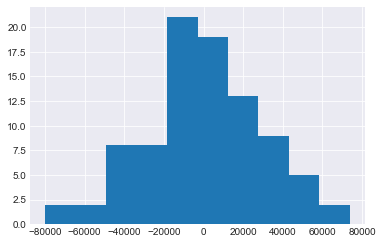

In [63]:
model_212_11012.resid.hist()

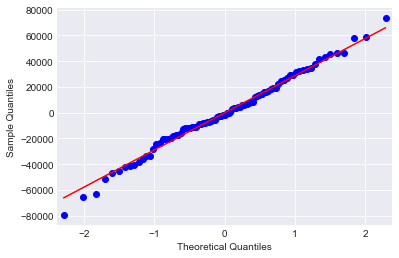

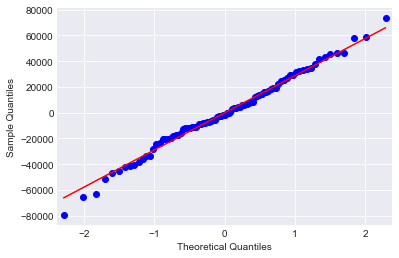

In [64]:
qqplot(model_212_11012.resid, line = 's' )

## Residuals look normal for both models.

## Will start with SARIMA (2,1,2) (0,1,1,12) and SARIMA (2,1,2)(1,1,0,12) going forward. Next, look at monthly average weather and precipitation as regressors.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c1c1d1ba8>,
      dtype=object)

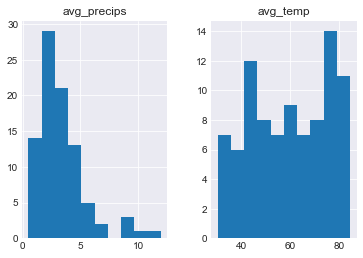

In [65]:
train_m[['avg_temp','avg_precips']].hist()

In [66]:
scale = MinMaxScaler()
scale.fit(train_m[['avg_temp','avg_precips']])

MinMaxScaler(copy=True, feature_range=(0, 1))

In [67]:
train_m_scaled = train_m.copy()
test_m_scaled = test_m.copy()

In [68]:
train_m_scaled[['avg_temp','avg_precips']] = scale.transform(train_m_scaled[['avg_temp','avg_precips']])
test_m_scaled[['avg_temp','avg_precips']] = scale.transform(test_m_scaled[['avg_temp','avg_precips']])

In [69]:
train_m_scaled[['avg_temp','avg_precips']].corr()

avg_temp  avg_precips
avg_temp     1.000000     0.289243
avg_precips  0.289243     1.000000

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c1c239588>,
      dtype=object)

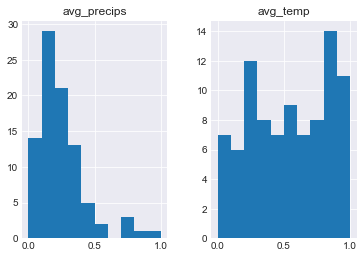

In [70]:
train_m_scaled[['avg_temp','avg_precips']].hist()

In [71]:
exog_train = np.array([train_m_scaled['avg_temp'], train_m_scaled['avg_precips']]).T
exog_test = np.array([test_m_scaled['avg_temp'], test_m_scaled['avg_precips']]).T

In [89]:
model_with_weather_212_01012 = sm.tsa.statespace.SARIMAX(train_m['count'], trend='n', order=(2,1,2), exog = exog_train,
                                          seasonal_order=(0,1,0,12)).fit()

In [91]:
model_with_weather_212_01012.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              count   No. Observations:                   89
Model:             SARIMAX(2, 1, 2)x(0, 1, 0, 12)   Log Likelihood                -856.383
Date:                            Tue, 10 Sep 2019   AIC                           1726.766
Time:                                    13:15:03   BIC                           1743.081
Sample:                                09-30-2010   HQIC                          1733.286
                                     - 01-31-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1          2.492e+05   2.37e+04     10.497      0.000    2.03e+05    2.96e+05
x2         -5.221e+04   7438.885     -7.019      0.000   -6.68e+04   -3.76e+04
ar.L1         -0.4417      0.191     -2.316      0.021      -0.816      -0.068
ar.L2          0.2612      0.142      1.846      0.065      -0.016       0.539
ma.L1          0.1921      0.145      1.325      0.185      -0.092       0.476
ma.L2         -0.7191      0.116     -6.191      0.000      -0.947      -0.491
sigma2       3.84e+08      0.508   7.56e+08      0.000    3.84e+08    3.84e+08
===================================================================================
Ljung-Box (Q):                       37.42   Jarque-Bera (JB):                 0.16
Prob(Q):                              0.59   Prob(JB):                         0.92
Heteroskedasticity (H):               1.71   Skew:                            -0.01
Prob(H) (two-sided):                  0.19   Kurtosis:                         3.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.23e+24. Standard errors may be unstable.
"""

In [92]:
mse.compare_mse_exog(model_with_weather_212_01012, train_m_scaled, test_m_scaled)

Training MSE:  1.29e+09
Testing MSE:  2.67e+09


(1285792033.9498692, 2669195297.3806095)

In [93]:
mse.compare_mse(model_212_01012, train_m, test_m)

Training MSE:  8.52e+08
Testing MSE:  7.23e+08


(851544503.868553, 722671588.1735687)

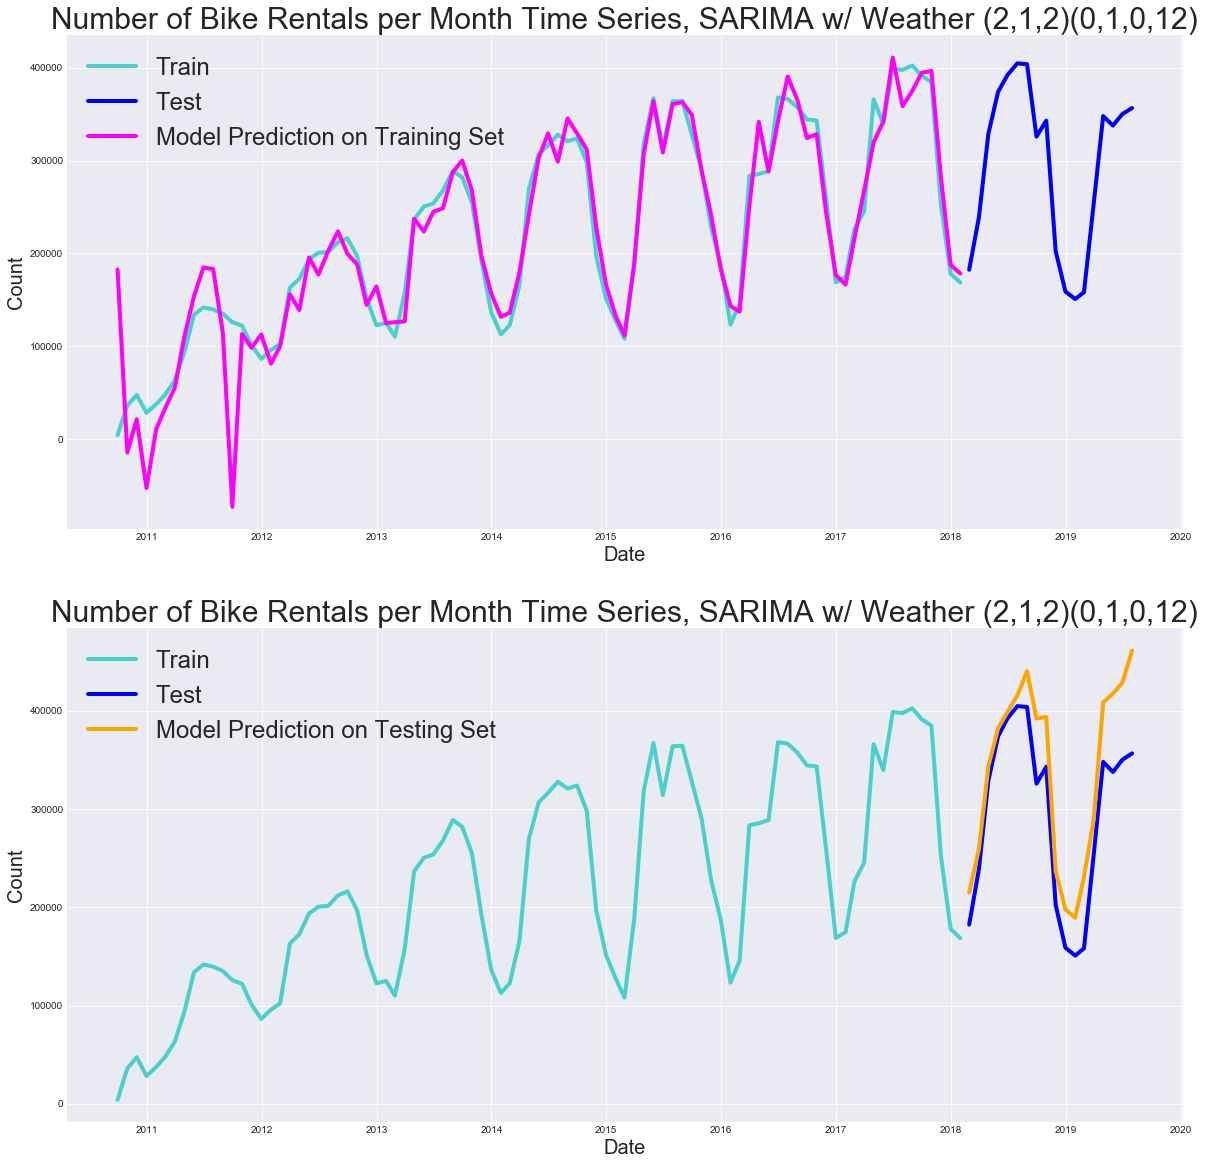

In [94]:
pplot.prediction_plot_exog(model_with_weather_212_01012 , train_m_scaled, test_m_scaled, 2,1,2,0,1,0,12)

In [79]:
model_with_weather_212_01112 = sm.tsa.statespace.SARIMAX(train_m['count'], trend='n', order=(2,1,2), exog = exog_train,
                                          seasonal_order=(0,1,1,12)).fit()

In [80]:
model_with_weather_212_01112.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              count   No. Observations:                   89
Model:             SARIMAX(2, 1, 2)x(0, 1, 1, 12)   Log Likelihood                -856.138
Date:                            Tue, 10 Sep 2019   AIC                           1728.276
Time:                                    13:13:05   BIC                           1746.922
Sample:                                09-30-2010   HQIC                          1735.727
                                     - 01-31-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1          2.492e+05   2.56e+04      9.720      0.000    1.99e+05    2.99e+05
x2         -5.221e+04   7923.193     -6.590      0.000   -6.77e+04   -3.67e+04
ar.L1         -0.4101      0.213     -1.928      0.054      -0.827       0.007
ar.L2          0.2526      0.169      1.497      0.134      -0.078       0.583
ma.L1          0.1785      0.162      1.102      0.270      -0.139       0.496
ma.L2         -0.6877      0.145     -4.730      0.000      -0.973      -0.403
ma.S.L12      -0.0782      0.066     -1.176      0.240      -0.209       0.052
sigma2       3.84e+08      0.354   1.09e+09      0.000    3.84e+08    3.84e+08
===================================================================================
Ljung-Box (Q):                       35.32   Jarque-Bera (JB):                 0.08
Prob(Q):                              0.68   Prob(JB):                         0.96
Heteroskedasticity (H):               1.55   Skew:                            -0.05
Prob(H) (two-sided):                  0.28   Kurtosis:                         3.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.71e+25. Standard errors may be unstable.
"""

In [81]:
mse.compare_mse_exog(model_with_weather_212_01112, train_m_scaled, test_m_scaled)

Training MSE:  1.23e+09
Testing MSE:  2.45e+09


(1234060783.48534, 2445402743.06402)

In [82]:
mse.compare_mse(model_212_01112, train_m, test_m)

Training MSE:  8.31e+08
Testing MSE:  5.90e+08


(830523283.9283372, 590314659.8871135)

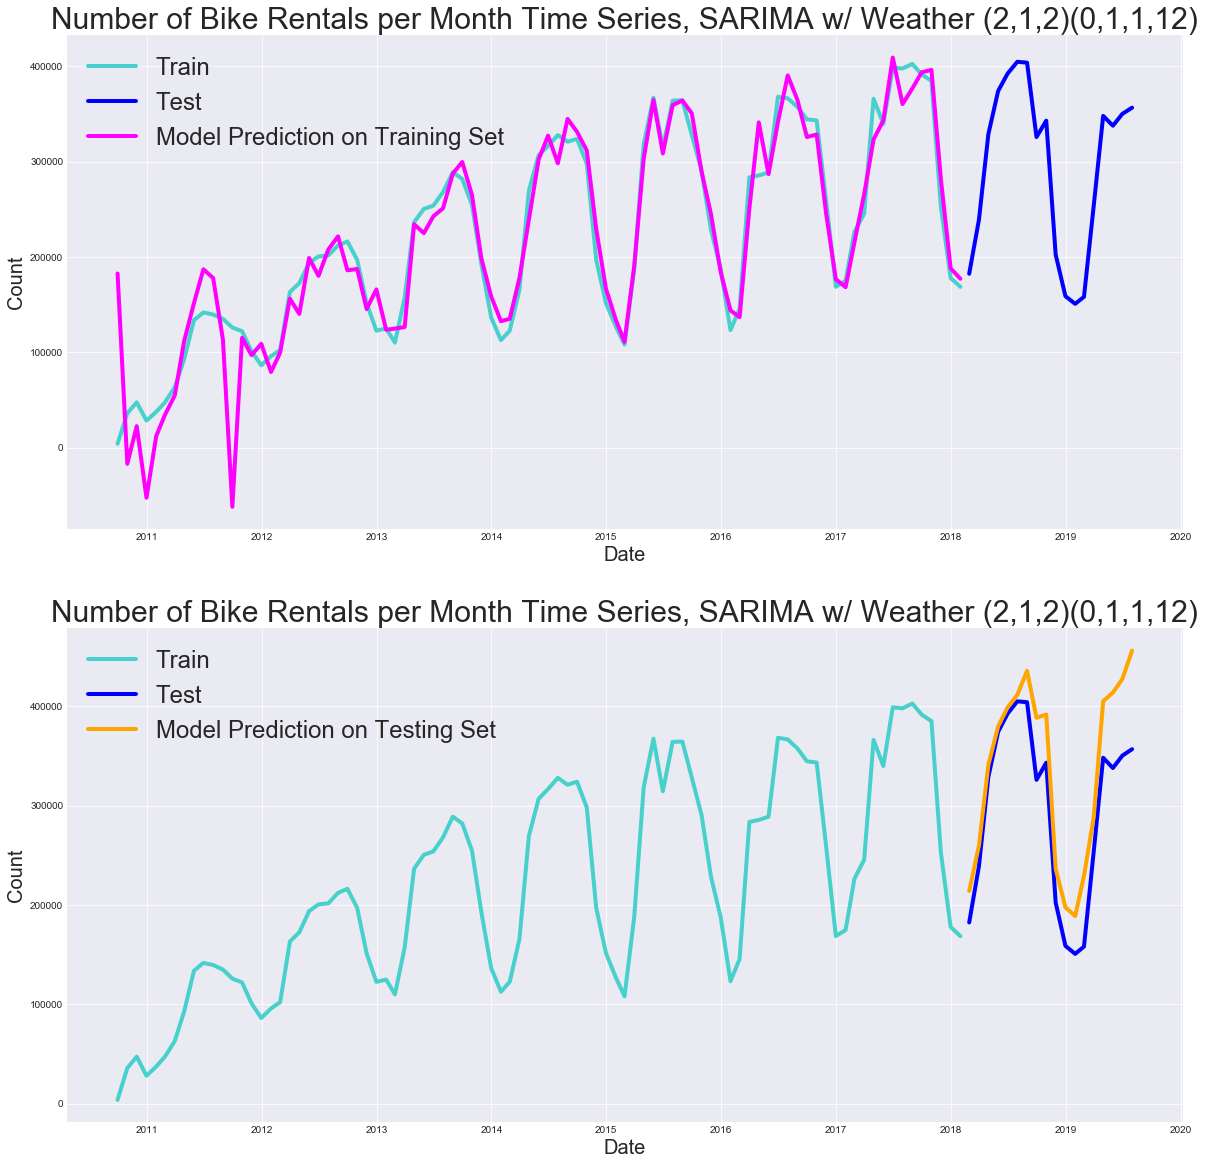

In [83]:
pplot.prediction_plot_exog(model_with_weather_212_01112 , train_m_scaled, test_m_scaled, 2,1,2,0,1,1,12)

In [84]:
model_with_weather_212_11012 = sm.tsa.statespace.SARIMAX(train_m['count'], trend='n', order=(2,1,2), exog = exog_train,
                                          seasonal_order=(1,1,0,12)).fit()

In [85]:
model_with_weather_212_11012.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              count   No. Observations:                   89
Model:             SARIMAX(2, 1, 2)x(1, 1, 0, 12)   Log Likelihood                -856.248
Date:                            Tue, 10 Sep 2019   AIC                           1728.495
Time:                                    13:13:35   BIC                           1747.141
Sample:                                09-30-2010   HQIC                          1735.947
                                     - 01-31-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1          2.492e+05   2.49e+04     10.017      0.000       2e+05    2.98e+05
x2         -5.221e+04   7731.197     -6.753      0.000   -6.74e+04   -3.71e+04
ar.L1         -0.4247      0.203     -2.090      0.037      -0.823      -0.026
ar.L2          0.2548      0.156      1.632      0.103      -0.051       0.561
ma.L1          0.1840      0.154      1.193      0.233      -0.118       0.486
ma.L2         -0.7005      0.132     -5.306      0.000      -0.959      -0.442
ar.S.L12      -0.0413      0.067     -0.612      0.540      -0.173       0.091
sigma2       3.84e+08      0.317   1.21e+09      0.000    3.84e+08    3.84e+08
===================================================================================
Ljung-Box (Q):                       36.26   Jarque-Bera (JB):                 0.10
Prob(Q):                              0.64   Prob(JB):                         0.95
Heteroskedasticity (H):               1.62   Skew:                            -0.04
Prob(H) (two-sided):                  0.23   Kurtosis:                         3.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.73e+25. Standard errors may be unstable.
"""

In [86]:
mse.compare_mse_exog(model_with_weather_212_11012, train_m_scaled, test_m_scaled)

Training MSE:  1.26e+09
Testing MSE:  2.55e+09


(1258335116.46989, 2551462867.2995553)

In [87]:
mse.compare_mse(model_212_11012, train_m, test_m)

Training MSE:  8.35e+08
Testing MSE:  6.21e+08


(834872166.7475387, 621135936.9546312)

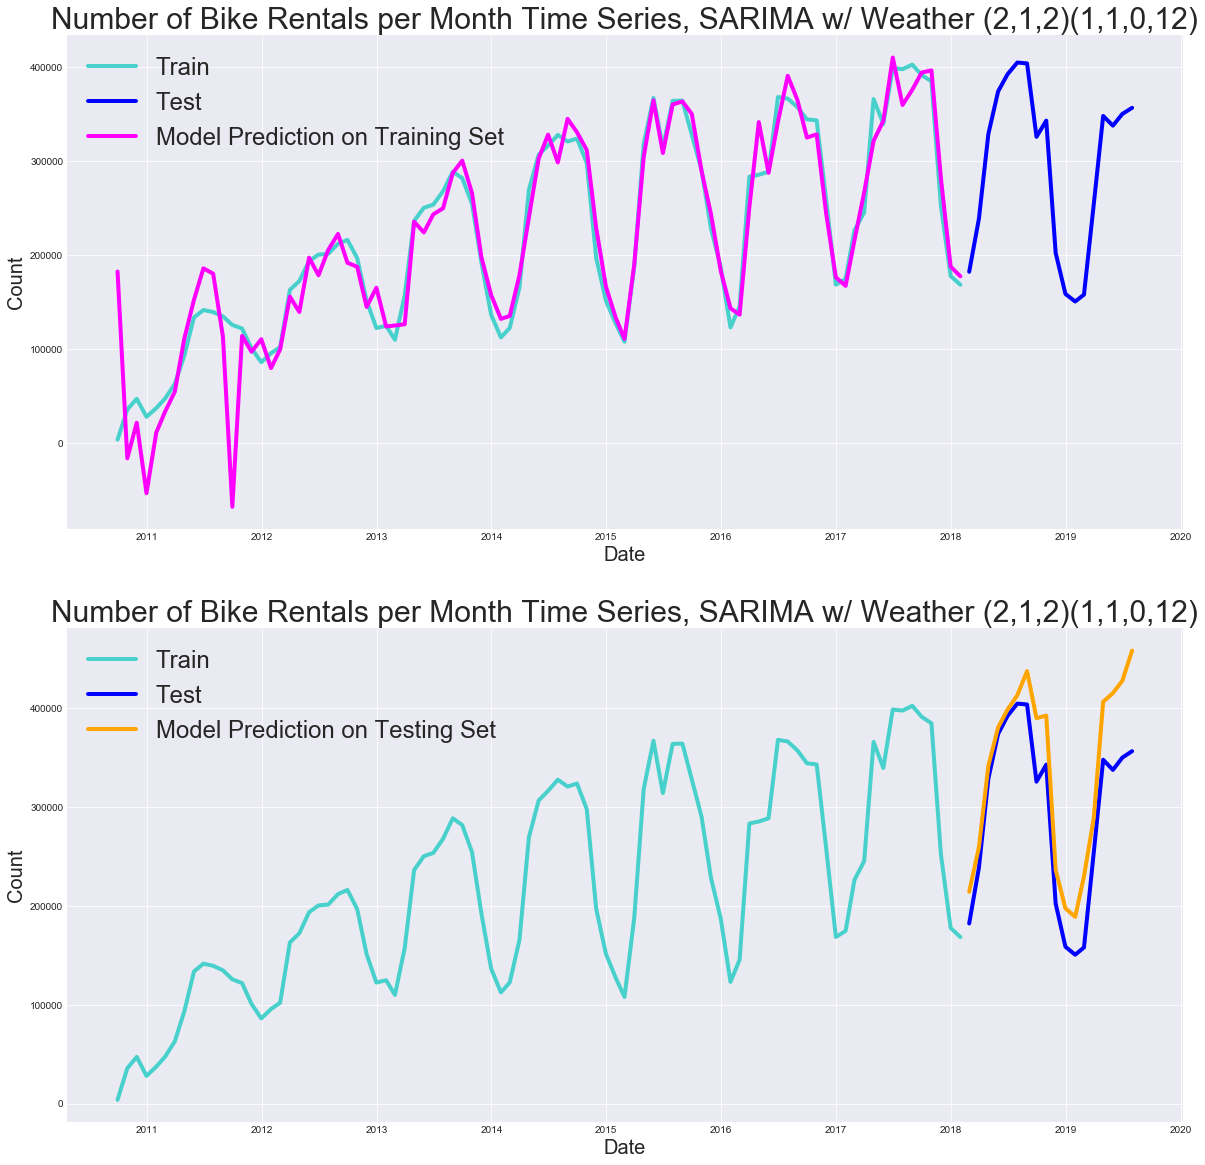

In [88]:
pplot.prediction_plot_exog(model_with_weather_212_11012 , train_m_scaled, test_m_scaled, 2,1,2,1,1,0,12)

## Adding weather patterns as regressors results in highly insignificant ma.S.L12 for (2,1,2)(0,1,1,12) and highly insignificant ar.S.L12 for (2,1,2)(1,1,0,12). On models without these terms, which is (2,1,2)(0,1,0,12), we have an overall worse fit. Therefore, do not consider weather.

## Best Model still appears to be SARIMA (2,1,2)(0,1,1,12) without Weather.

In [97]:
mse_dict

{'(2, 1, 0),(0, 1, 0, 12)': {'Training MSE': '1.00e+09',
  'Testing MSE': '1.08e+09'},
 '(2, 1, 0),(1, 1, 0, 12)': {'Training MSE': '9.78e+08',
  'Testing MSE': '1.12e+09'},
 '(2, 1, 0),(0, 1, 1, 12)': {'Training MSE': '9.77e+08',
  'Testing MSE': '1.07e+09'},
 '(2, 1, 1),(0, 1, 0, 12)': {'Training MSE': '1.00e+09',
  'Testing MSE': '1.08e+09'},
 '(2, 1, 1),(1, 1, 0, 12)': {'Training MSE': '9.75e+08',
  'Testing MSE': '1.09e+09'},
 '(2, 1, 1),(0, 1, 1, 12)': {'Training MSE': '9.73e+08',
  'Testing MSE': '1.04e+09'},
 '(2, 1, 2),(0, 1, 0, 12)': {'Training MSE': '8.52e+08',
  'Testing MSE': '7.23e+08'},
 '(2, 1, 2),(1, 1, 0, 12)': {'Training MSE': '8.35e+08',
  'Testing MSE': '6.21e+08'},
 '(2, 1, 2),(0, 1, 1, 12)': {'Training MSE': '8.31e+08',
  'Testing MSE': '5.90e+08'},
 '(2, 1, 3),(0, 1, 0, 12)': {'Training MSE': '8.56e+08',
  'Testing MSE': '7.10e+08'},
 '(2, 1, 3),(1, 1, 0, 12)': {'Training MSE': '8.39e+08',
  'Testing MSE': '6.26e+08'},
 '(2, 1, 3),(0, 1, 1, 12)': {'Training MSE'

In [95]:
model_212_01112.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              count   No. Observations:                   89
Model:             SARIMAX(2, 1, 2)x(0, 1, 1, 12)   Log Likelihood                -890.763
Date:                            Tue, 10 Sep 2019   AIC                           1793.525
Time:                                    13:18:00   BIC                           1807.509
Sample:                                09-30-2010   HQIC                          1799.114
                                     - 01-31-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2962      0.095     -3.109      0.002      -0.483      -0.109
ar.L2         -0.8991      0.058    -15.409      0.000      -1.013      -0.785
ma.L1         -0.0344      0.134     -0.257      0.797      -0.297       0.228
ma.L2          0.7953      0.125      6.340      0.000       0.549       1.041
ma.S.L12      -0.1927      0.142     -1.358      0.175      -0.471       0.085
sigma2      1.009e+09   2.08e-11   4.84e+19      0.000    1.01e+09    1.01e+09
===================================================================================
Ljung-Box (Q):                       36.66   Jarque-Bera (JB):                 0.01
Prob(Q):                              0.62   Prob(JB):                         0.99
Heteroskedasticity (H):               2.52   Skew:                            -0.00
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.51e+35. Standard errors may be unstable.
"""

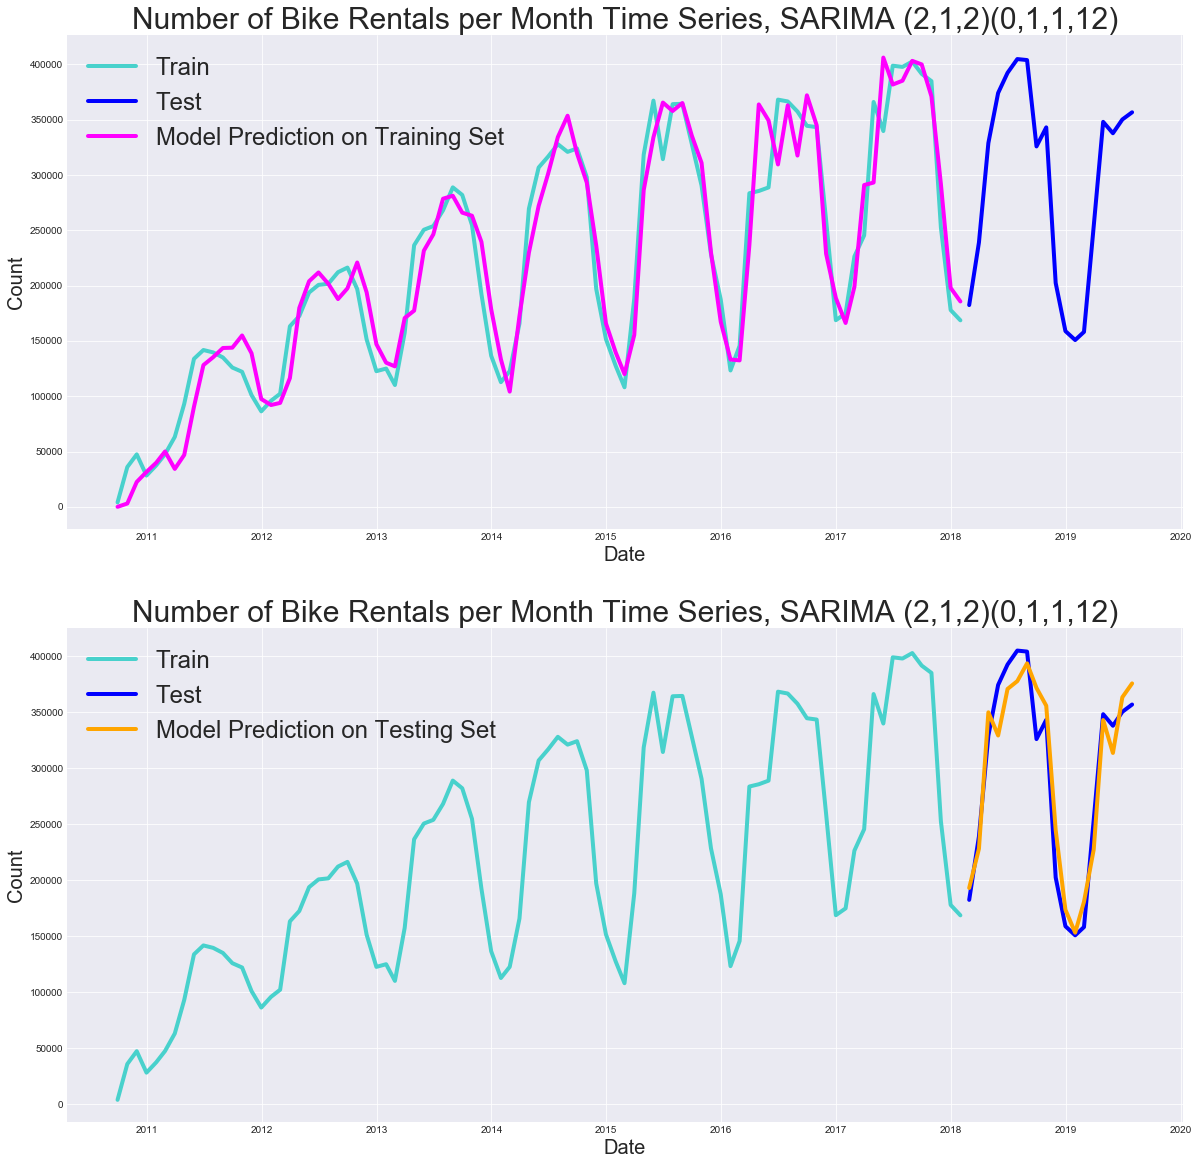

In [133]:
pplot.prediction_plot(model_212_01112,train_m, test_m, 2,1,2,0,1,1,12)

In [115]:
forecast_12_conf_int =  model_212_01112.get_forecast(len(test_m) + 12).conf_int(alpha = .2)

In [116]:
forecast_12_conf_int

lower count    upper count
2018-02-28  152284.394815  233699.452290
2018-03-31  179035.864589  277010.545213
2018-04-30  293775.600823  405657.427064
2018-05-31  260710.798283  397305.523767
2018-06-30  293431.808932  447647.697237
2018-07-31  296192.356248  458846.524025
2018-08-31  306009.353379  480688.109618
2018-09-30  275777.238836  467084.436142
2018-10-31  254867.503315  456280.572274
2018-11-30  140338.884962  349012.875002
2018-12-31   63415.534358  283697.070572
2019-01-31   37042.383958  269232.676691
2019-02-28   49034.054859  312217.694408
2019-03-31   85827.908866  368864.778226
2019-04-30  189696.827564  495908.272047
2019-05-31  146929.685592  479933.649945
2019-06-30  186940.067542  539333.393800
2019-07-31  191300.596866  559667.701194
2019-08-31  188087.285211  576662.346640
2019-09-30  154031.363450  562525.008694
2019-10-31  139504.334601  562702.574336
2019-11-30   20572.126202  458613.419410
2019-12-31  -67079.064580  388776.082325
2020-01-31  -92463.469165  378940.922248
2020-02-29  -74810.522114  428311.548909
2020-03-31  -45201.798871  483524.577840
2020-04-30   52994.805450  607961.769756
2020-05-31   14684.910172  597731.411050
2020-06-30   54422.085632  661826.253263
2020-07-31   50693.760185  679767.504982

In [117]:
forecast_12 = model_212_01112.forecast(len(test_m) + 12)

In [118]:
forecast_12.index

DatetimeIndex(['2018-02-28', '2018-03-31', '2018-04-30', '2018-05-31',
               '2018-06-30', '2018-07-31', '2018-08-31', '2018-09-30',
               '2018-10-31', '2018-11-30', '2018-12-31', '2019-01-31',
               '2019-02-28', '2019-03-31', '2019-04-30', '2019-05-31',
               '2019-06-30', '2019-07-31', '2019-08-31', '2019-09-30',
               '2019-10-31', '2019-11-30', '2019-12-31', '2020-01-31',
               '2020-02-29', '2020-03-31', '2020-04-30', '2020-05-31',
               '2020-06-30', '2020-07-31'],
              dtype='datetime64[ns]', freq='M')

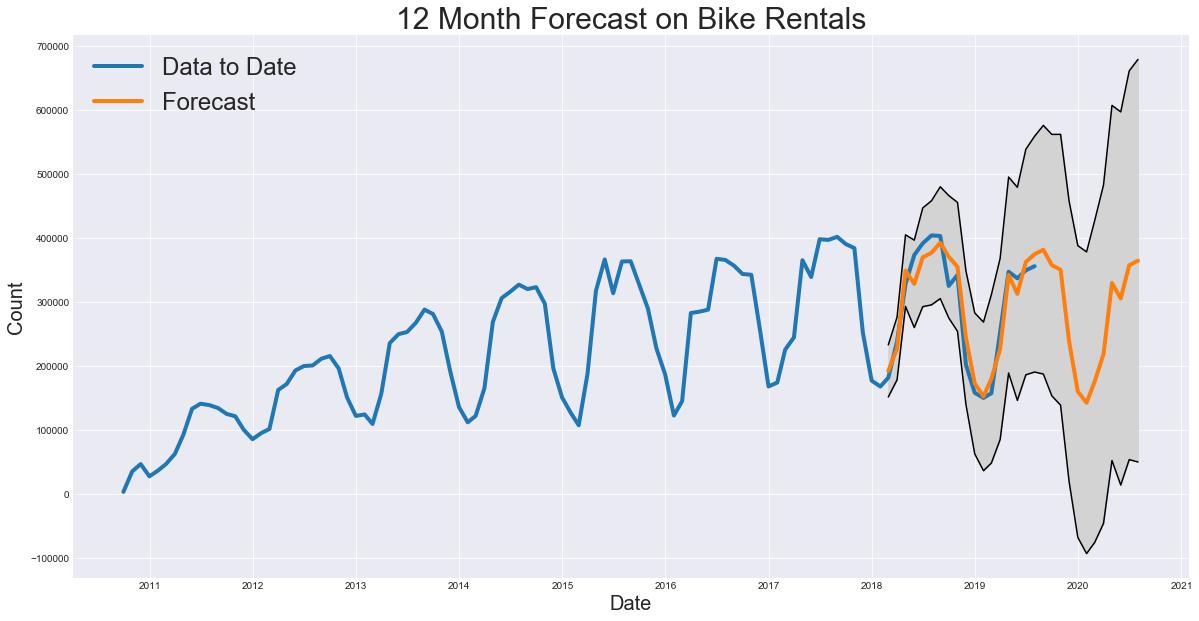

In [127]:
fig = plt.figure(figsize = (20,10))
plt.plot(master_m.index,master_m['count'], lw = 4)
plt.plot(forecast_12.index, forecast_12, lw = 4)
plt.plot(forecast_12_conf_int.index, forecast_12_conf_int['lower count'], color = 'black')
plt.plot(forecast_12_conf_int.index, forecast_12_conf_int['upper count'], color = 'black')
plt.fill_between(forecast_12_conf_int.index,forecast_12_conf_int['lower count'],forecast_12_conf_int['upper count'], color = 'lightgray')
plt.title('12 Month Forecast on Bike Rentals', fontsize = 30)
plt.xlabel('Date', fontsize = 20)
plt.ylabel('Count', fontsize = 20)
plt.legend(['Data to Date', 'Forecast'],prop={'size': 24})